In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits#
import matplotlib.patches as patches
from copy import copy

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/azoft-sans.ttf'  # Your font path goes here
font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif', 'DejaVu Sans']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rc('axes', unicode_minus=False)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
from rtfunctions import one_full_fs, sc_2nd_order, calc_lambda_full, calc_lambda_monoc

<h1>Finite slab</h1>

<p>We want to solve radiative transfer problem in finite slab, that is in bounded part of the atmosphere. We assume two level atom model and non-LTE conditions. For starters we shall focus on non-illuminated free-standing finite slab, and will work our way to the illuminated case.</p>

In [4]:
# Let's define the solver function for ALI approach

# It should only deal with solving radiative transfer problem
from scipy.special import wofz
def two_lvl_nlte_solver(tau, NM, NL, B, eps, profile_type, low_bound, up_bound, lratio = 0):
    ND = len(tau) # number of optical depth points
    logtau = np.log10(tau)
    # tau - optical depth grid in form of np.array
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # Planck's function
    B_arr = np.zeros(ND)
    B_arr[:] = B

    # Photon destruction probability
    epsilon = np.zeros(ND)
    epsilon[:] = eps

    # Reduced wavlength in Doppler widths
    x = np.linspace(-6, 6, NL)

    # Profile type: Doppler, Voight or Lorentz
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        # sigma = 1
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        print("Profile type must be 1, 2 or 3")

    # Quadrature (at some point in the future this will be in separate function)
    
    # Weights for wavelengths
    
    wx = np.zeros(NL)
    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]

    # Third approximation
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    
    #Fourth approximation
    #mu = np.array([0.06943184, 0.33000948, 0.66999052, 0.93056816])
    #wmu = [0.173927419815906, 0.326072580184089, 0.326072580184104, 0.173927419815900]
    
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)

    # One figure for plotting the source function
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Relative error
    rel_err = np.zeros((500))
    res = [] # in case we want this function to return [S, Lamba_operator]
    
    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B_arr) # the source function 
    # We will iterate 'till the convergence
    for j in range(0, 500):
        J = np.zeros(ND) # initialize the scattering integral
        L = np.zeros(ND) # initialize the Lambda operator
        # For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral
        for m in range(0, NM):
            for l in range(0, NL):

                # outward

                I_Lambda = sc_2nd_order(tau * profile[l] * (1 + lratio), S, mu[m], low_bound)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

                # inward

                I_Lambda = sc_2nd_order(tau * profile[l] * (1 + lratio), S, -mu[m], up_bound)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

        # Correct the source function using the local ALI approach
        dS = (epsilon * B_arr + (1. - epsilon) * J - S)/(1. - (1. - epsilon) * L)

        # Check for change
        max_change = np.max(np.abs(dS/S))
        rel_err[j] = max_change
        #print(rel_err[j])

        S += dS
        plt.semilogy(logtau, S, '-k', alpha = 0.20)
        if(max_change < 1E-4):
            break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("$\\log$S")
    #LL = calc_lambda_full(tau * lratio, mu, wmu, profile, wx)
    # res.append(fin)
    # res.append(LL)
    # return res
    return fin
    

In [5]:
# Here we define function for basic lambda iteration
def two_level_atom_LI(tau, NM, NL, B, eps, profile_type, low_bound, up_bound, lratio = 1E3):
    ND = len(tau) # number of optical depth points
    logtau = np.log10(tau)
    # tau - optical depth grid in form of np.array
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # Planck's function
    B_arr = np.zeros(ND)
    B_arr[:] = B

    # Photon destruction probability
    epsilon = np.zeros(ND)
    epsilon[:] = eps

    # Reduced wavlength in Doppler widths
    x = np.linspace(-6, 6, NL)

    # Profile type: Doppler, Voight or Lorentz
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        print("Profile type must be 1, 2 or 3")

    # Quadrature (at some point in the future this will be in separate function)
    
    # Weights for wavelengths
    
    wx = np.zeros(NL)
    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    #mu = [-np.sqrt(3)/3, 0, np.sqrt(3)/3]
    #wmu = [5/9, 8/9, 5/9]
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)

    # One figure for plotting the source function
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Relative error
    rel_err = np.zeros((1000))
    res = [] # in case we want this function to return [S, Lamba_operator]
    
    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B_arr) # the source function 
    for iter in range(0,1000):
    # initialize the scattering integral
        J = np.zeros(ND)
        for m in range(0,NM):
            for l in range(0,NL):
                #outward
                I = sc_2nd_order(tau*profile[l]*lratio,S,mu[m],low_bound)[0]
                J+=I*profile[l]*wx[l]*wmu[m]*0.5
                #inward
                I = sc_2nd_order(tau*profile[l]*lratio,S,-mu[m],up_bound)[0]
                J+=I*profile[l]*wx[l]*wmu[m]*0.5
        
        dS = eps * B + (1.-eps)*J - S
        max_change = np.amax(np.abs(dS/S))
        #print (max_change)
        S += dS
        plt.semilogy(logtau+3, S,'-k',alpha=0.2)
        if(max_change < 1E-4):
                break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("Source function")

    return fin

In [6]:
# Let's define a function that defines the finite slab in terms of optical depth 
# and return the log_tau grid

# We want a slab with given optical thickness T, and some minimum thickne at the surface. 
# And we want given number of points per decade. 
# AND we want the slab to be symmetric around the middle, meaning very fine separation at the edges and coarse 
# in the middle.

def tau_grid(taumin, taumax, np_per_dec):
    # How many decades in total?
    n_decades = np.log10(taumax / taumin)
    print(n_decades)

    # How many decades until the middle of the slab?
    n_dec_mid = np.log10(taumax / taumin / 2)
    print(n_dec_mid)

    # Total number of points is then: 
    ND = int (np_per_dec * n_dec_mid) + 1
    print(ND)

    # Now, the step is, actually: 
    logstep = np.log10(taumax / taumin / 2) / (ND - 1)
    print(logstep)

    # Make log grid for a half of the slab:
    logtau_half = np.linspace(np.log10(taumin), np.log10(taumax/2), ND)

    tau_half = 10**logtau_half

    #print(tau_half)

    tau_second_half = taumax - tau_half[::-1]

    tau_full = np.concatenate((tau_half, tau_second_half[1:]))

    print(tau_full)

    return tau_full
    

In [7]:
def element_difference(arr):
    diff_arr = np.zeros(len(arr))
    for j in range(len(arr)):
        nth_from_start = arr[j - 1] # Python lists are 0-indexed
        nth_from_end = arr[-j]
        diff_arr[j] = nth_from_start - nth_from_end
        #print(f"Difference between {n}-th element from start and {n}-th from end: {difference}")
    return diff_arr

<h3>Mihalas (1978) results</h3>
<p>First and foremost goal is to obtain the results that Mihalas shows for finite free-standing slab (no illumination).</p>
<p>We start by reproducing <b><i>Fig. 11.3</i></b> and work our way through the rest of the chapter without extended atmospheres.</p>

8.0
7.698970004336019
93
0.08368445656886978
[1.00000000e-04 1.21250756e-04 1.47017459e-04 1.78259781e-04
 2.16141333e-04 2.62073002e-04 3.17765497e-04 3.85293068e-04
 4.67170760e-04 5.66448080e-04 6.86822582e-04 8.32777576e-04
 1.00974911e-03 1.22432843e-03 1.48450749e-03 1.79997656e-03
 2.18248519e-03 2.64627980e-03 3.20863427e-03 3.89049333e-03
 4.71725259e-03 5.71970444e-03 6.93518490e-03 8.40896415e-03
 1.01959326e-02 1.23626454e-02 1.49898011e-02 1.81752472e-02
 2.20376248e-02 2.67207867e-02 3.23991560e-02 3.92842217e-02
 4.76324160e-02 5.77546647e-02 7.00279678e-02 8.49094406e-02
 1.02953339e-01 1.24831702e-01 1.51359383e-01 1.83524397e-01
 2.22524720e-01 2.69812906e-01 3.27150189e-01 3.96672079e-01
 4.80967896e-01 5.83177212e-01 7.07106781e-01 8.57372321e-01
 1.03957042e+00 1.26048700e+00 1.52835003e+00 1.85313597e+00
 2.24694138e+00 2.72443341e+00 3.30339612e+00 4.00539279e+00
 4.85656905e+00 5.88862671e+00 7.14000443e+00 8.65730937e+00
 1.04970531e+01 1.27277563e+01 1.5432500

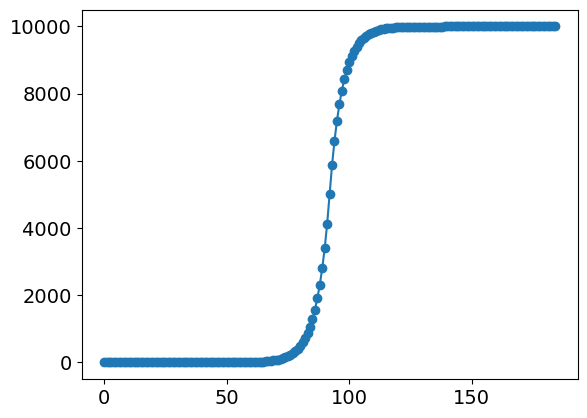

In [8]:
# Create tau grid
tau = tau_grid(1E-4, 1E4, 12)
# Upper boundary affects the S!!!!!
# If taumin (tau_upper) = 1E-5 for instance, the results are very different!!!!
logtau = np.log10(tau)
#logtau = np.linspace(-5, 10, 209)
plt.plot(tau, '-o')

<h3><b>ALI</b> - accelerated (approximate) $\Lambda$ - iteration</h3>

[0.10003474 0.10003688 0.10003946 0.1000426  0.1000464  0.10005101
 0.10005659 0.10006337 0.10007158 0.10008154 0.10009361 0.10010824
 0.10012597 0.10014747 0.10017352 0.1002051  0.10024337 0.10028973
 0.1003459  0.10041393 0.10049632 0.10059607 0.10071679 0.10086284
 0.10103945 0.1012529  0.10151069 0.1018218  0.10219688 0.10264856
 0.10319173 0.10384387 0.10462533 0.10555963 0.10667372 0.10799817
 0.10956726 0.11141898 0.11359495 0.11614034 0.11910388 0.12253839
 0.12650189 0.13105979 0.13628839 0.14227915 0.14914327 0.15701478
 0.16605079 0.17642774 0.18833427 0.20196256 0.21750041 0.23512527
 0.2549993  0.27726389 0.30203167 0.3293755  0.35931525 0.39180428
 0.4267173  0.46384042 0.50286339 0.54337505 0.58486417 0.62672866
 0.66829551 0.70885215 0.74768811 0.78414377 0.81766022 0.84782301
 0.87439201 0.89731148 0.91669802 0.93280884 0.94599726 0.95666467
 0.96521772 0.9720366  0.97745627 0.98175924 0.98517635 0.98789229
 0.99005277 0.99177176 0.99313782 0.99421916 0.99506736 0.9957

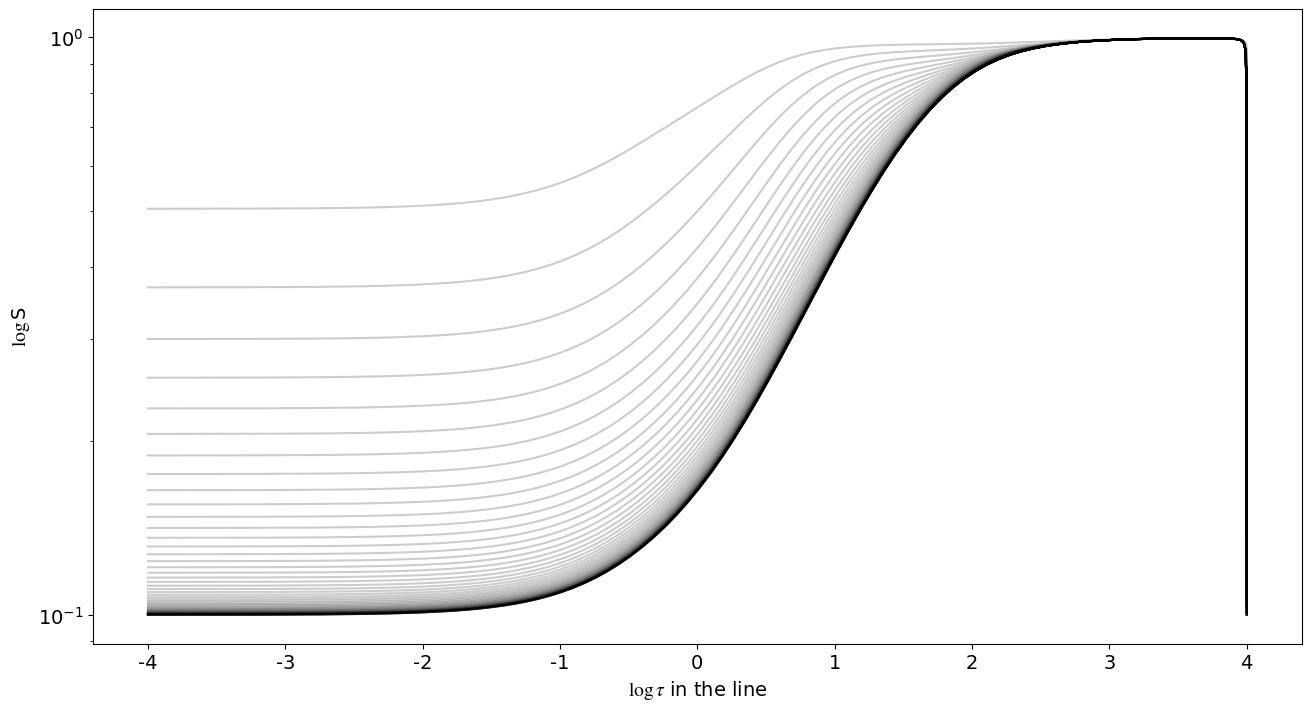

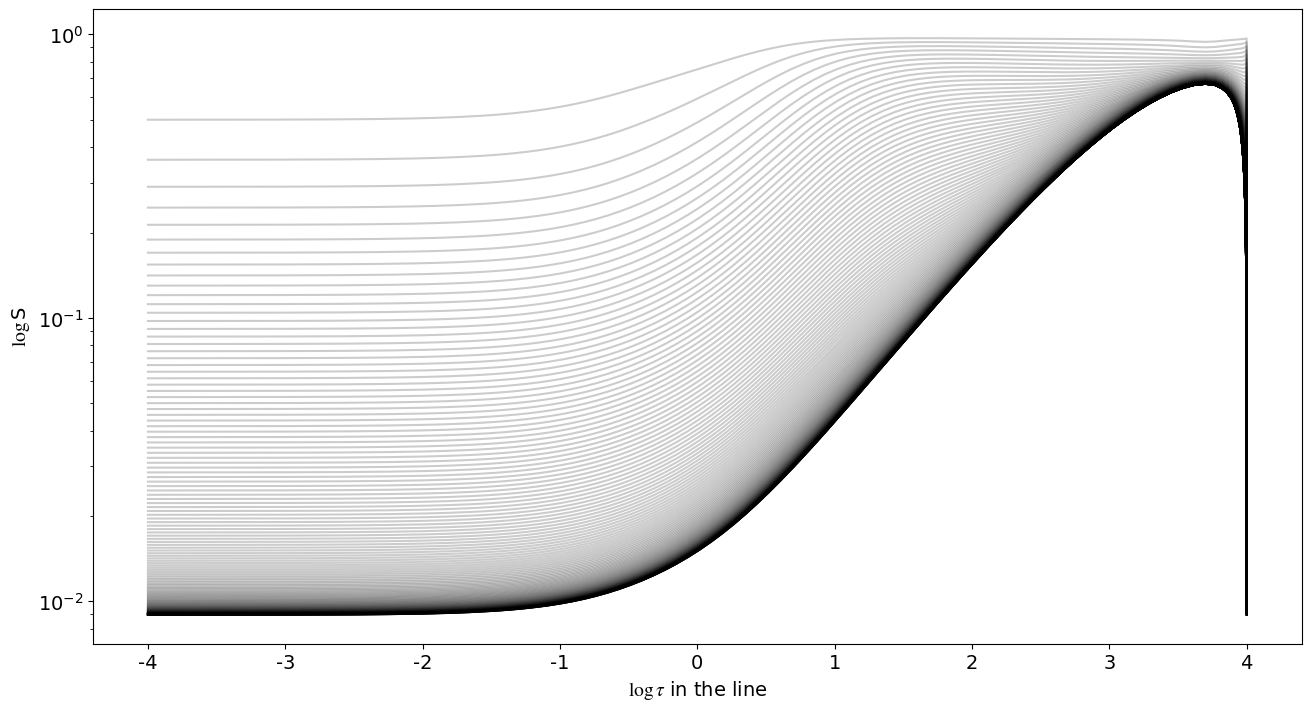

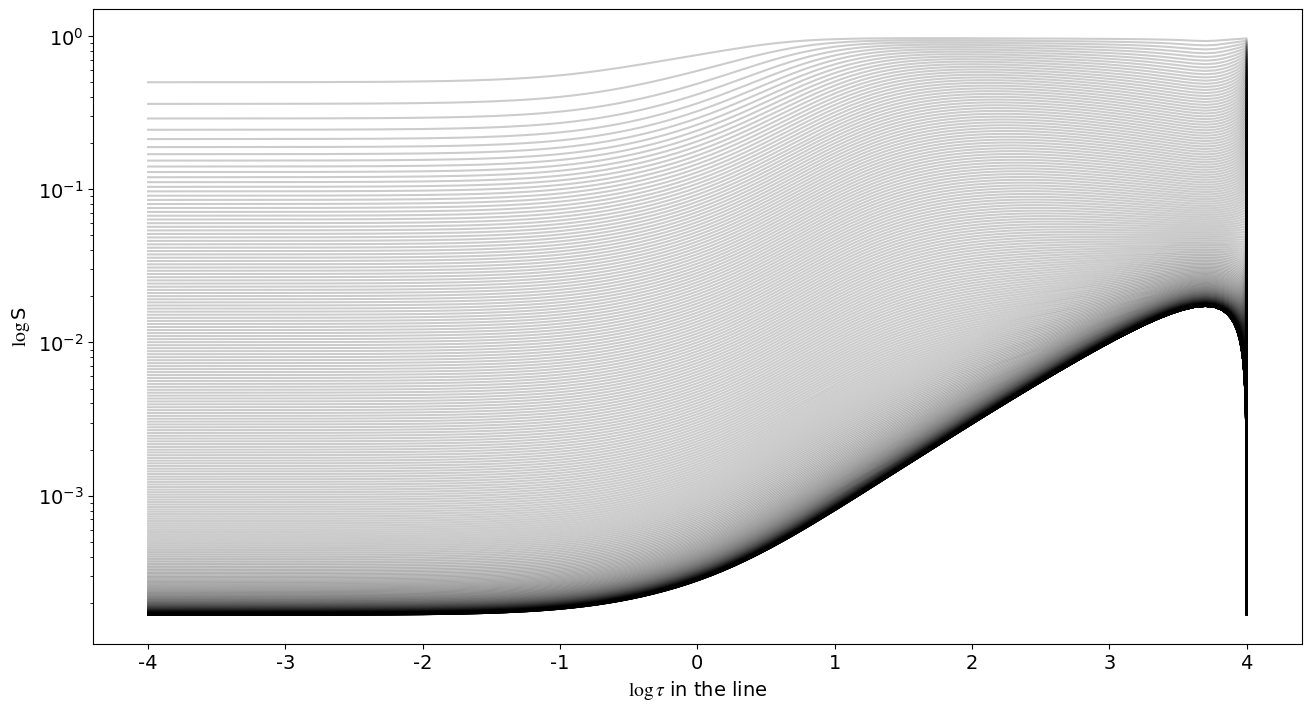

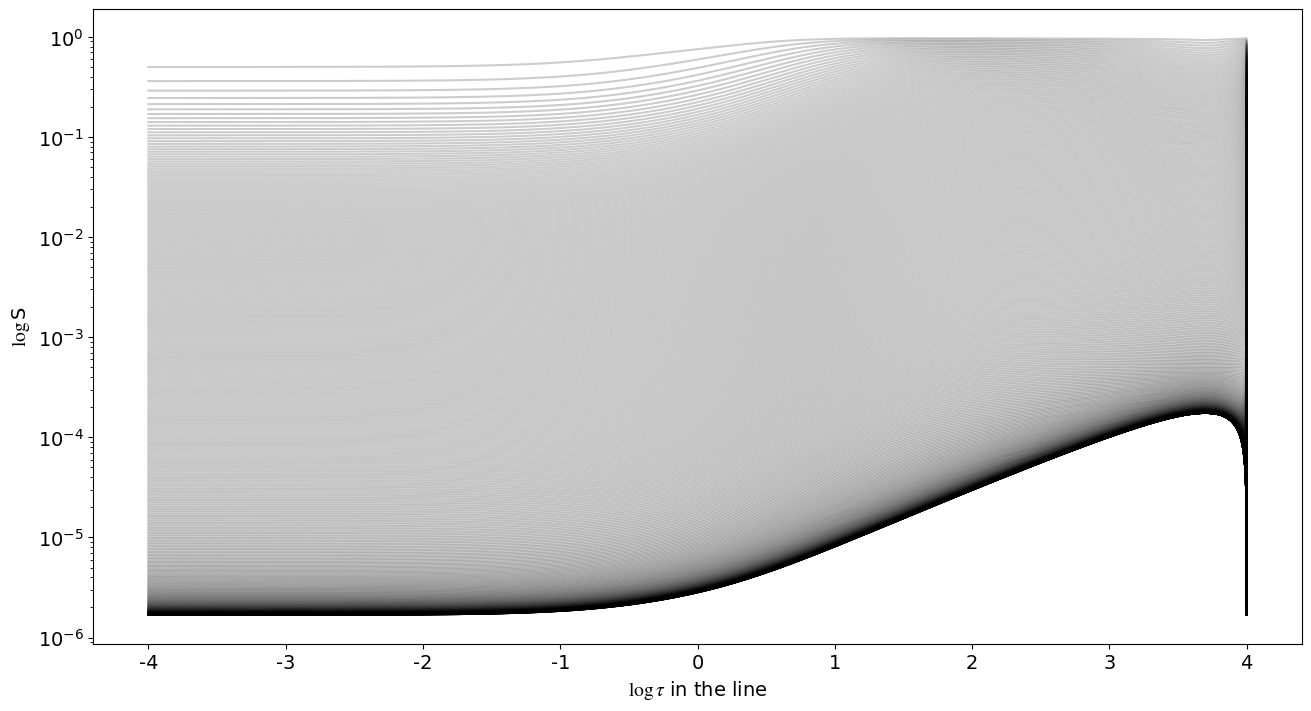

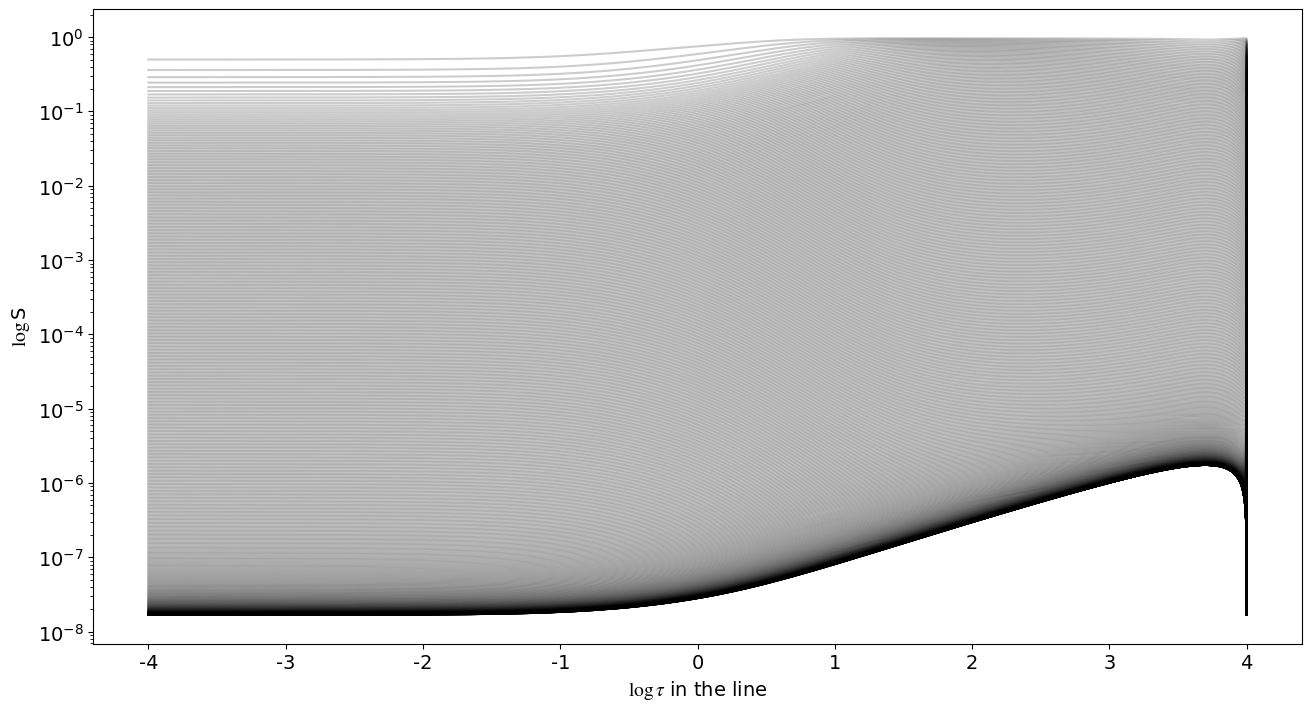

In [9]:
S_D_finite_e2_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-2, 1, low_bound = 0.0, up_bound = 0.0)
print(S_D_finite_e2_T4)
S_D_finite_e4_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e6_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-6, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e8_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-8, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e10_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-10, 1, low_bound = 0.0, up_bound = 0.0)

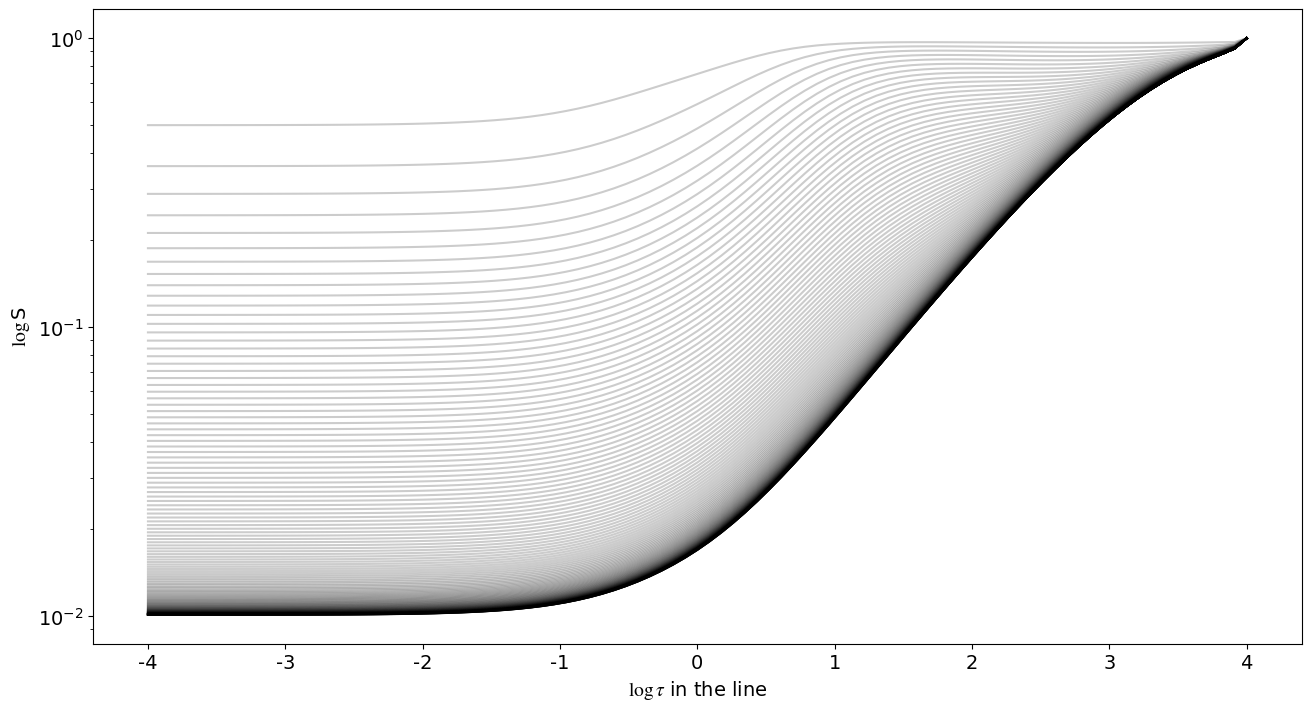

In [10]:
ltau = np.linspace(-4, 4, 93)
tau_l = 10**ltau
S_D_e4 = two_lvl_nlte_solver(tau_l, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)

In [11]:
print(len(S_D_finite_e2_T4))

185


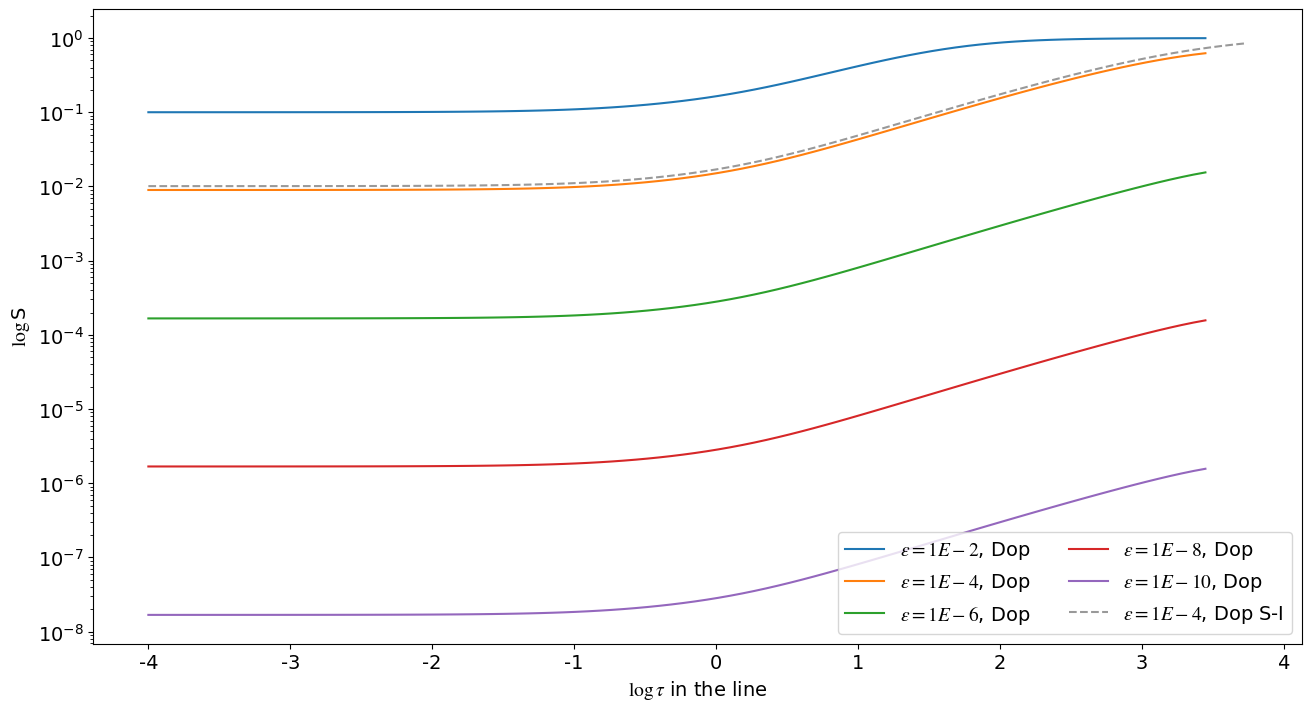

In [12]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau[:90], S_D_finite_e2_T4[:90], label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau[:90], S_D_finite_e4_T4[:90], label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau[:90], S_D_finite_e6_T4[:90], label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau[:90], S_D_finite_e8_T4[:90], label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau[:90], S_D_finite_e10_T4[:90], label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(ltau[:90], S_D_e4[:90], alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 2)

<h3>Is source function symmetric with regard to the middle of the slab?</h3>

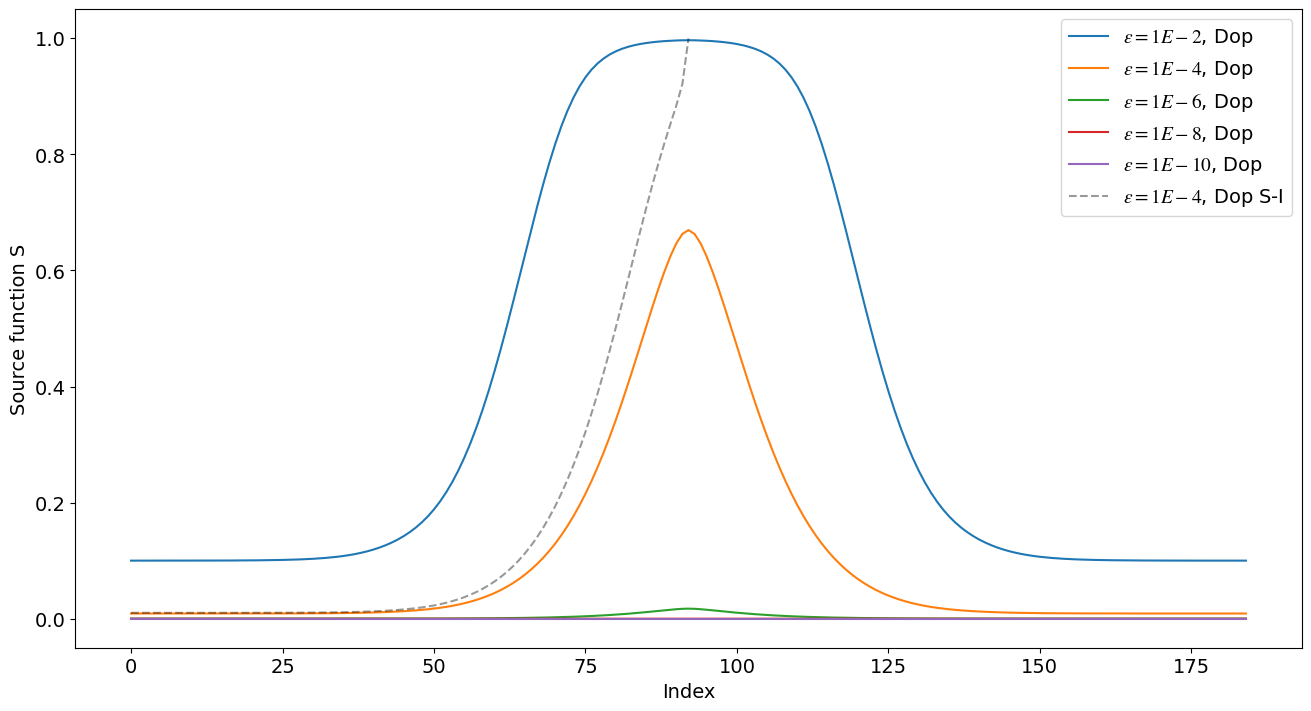

In [13]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("Index")
plt.ylabel("Source function S")
plt.plot(S_D_finite_e2_T4, label = "$\\varepsilon = 1E-2$, Dop")
plt.plot(S_D_finite_e4_T4, label = "$\\varepsilon = 1E-4$, Dop")
plt.plot(S_D_finite_e6_T4, label = "$\\varepsilon = 1E-6$, Dop")
plt.plot(S_D_finite_e8_T4, label = "$\\varepsilon = 1E-8$, Dop")
plt.plot(S_D_finite_e10_T4, label = "$\\varepsilon = 1E-10$, Dop")
plt.plot(S_D_e4, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "upper right", ncols = 1)

(185,)
(185,)
(185,)
(185,)
(185,)


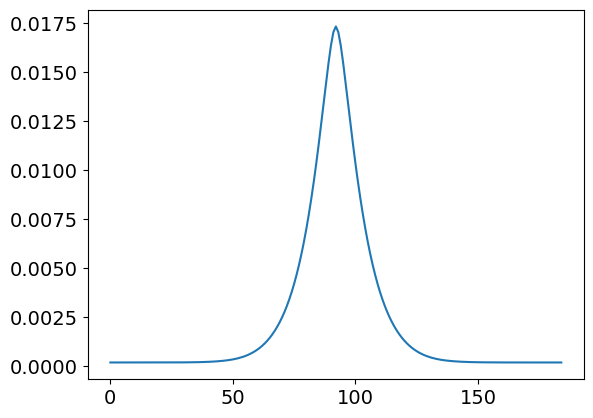

In [14]:
plt.plot(S_D_finite_e6_T4)
print(np.shape(S_D_finite_e2_T4))
print(np.shape(S_D_finite_e4_T4))
print(np.shape(S_D_finite_e6_T4))
print(np.shape(S_D_finite_e8_T4))
print(np.shape(S_D_finite_e10_T4))

In [15]:
S_D_finite_e6_T4_diff = element_difference(S_D_finite_e6_T4)
print(S_D_finite_e6_T4_diff)

[ 1.46367293e-17 -1.46367293e-17 -2.25785102e-17 -1.08149167e-16
 -6.05526913e-17 -2.32642681e-16 -7.74933503e-17 -1.23056947e-17
 -1.61817174e-17 -5.56466765e-17 -7.18012889e-17 -2.18737788e-17
 -2.29905071e-16 -3.16451509e-16 -6.74102701e-17 -1.32028720e-16
 -4.04136360e-17 -4.33680869e-17 -4.89246230e-17 -1.74529445e-16
 -2.45897053e-16 -2.48417823e-16 -1.96105068e-16 -2.55356717e-16
 -2.33103467e-16 -1.68864488e-17 -1.30890307e-16 -3.22008045e-16
 -2.23562488e-16 -1.01101853e-17 -2.98616383e-16 -2.31124798e-16
 -2.27384301e-16 -2.01634499e-16 -2.47848617e-16 -2.21041718e-16
 -4.15249432e-17 -2.29932176e-16 -1.55068016e-16 -1.04029198e-16
 -1.48047807e-16 -1.71656309e-16 -1.09206264e-16 -1.13190707e-16
 -5.12014476e-17 -1.69054224e-16 -1.04896560e-17 -1.06631284e-16
 -1.62142435e-16 -5.59990422e-17 -1.24141149e-17 -4.36933476e-17
 -1.55311961e-16 -1.50541472e-16 -6.35884574e-17 -7.51352106e-17
 -4.25007252e-17 -9.18319240e-17 -9.10729825e-17 -1.20888542e-16
 -1.34549490e-16 -1.39645

In [16]:
n = 20  
my_list = S_D_finite_e6_T4
if len(my_list) >= n and len(my_list) >= n: # Ensure n-th element from both ends exist
    nth_from_start = my_list[n - 1] # Python lists are 0-indexed
    nth_from_end = my_list[-n]
    difference = nth_from_start - nth_from_end
    print(f"Difference between {n}-th element from start and {n}-th from end: {difference}")
else:
    print("List is too short to get the n-th element from both ends.")

Difference between 20-th element from start and 20-th from end: -2.458970527197124e-16


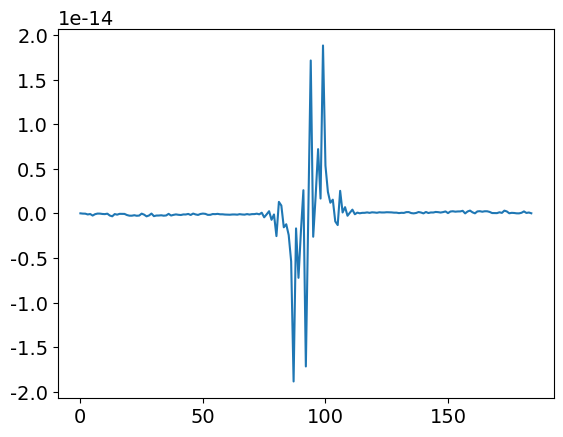

In [17]:
plt.plot(S_D_finite_e6_T4_diff)

<h3>Emergent intensity</h3>
<p>What does emergent intensity (the intensity that passes through) look like? We want to obtain <b><i>Fig. 11.4</i></b> from Mihalas.</p>

2.0
1.6989700043360187
21
0.08494850021680093
[0.01       0.01216042 0.01478758 0.01798231 0.02186724 0.02659148
 0.03233635 0.03932235 0.04781762 0.05814823 0.07071068 0.08598714
 0.10456396 0.12715414 0.15462475 0.18803015 0.22865253 0.27805103
 0.33812167 0.41117008 0.5        0.58882992 0.66187833 0.72194897
 0.77134747 0.81196985 0.84537525 0.87284586 0.89543604 0.91401286
 0.92928932 0.94185177 0.95218238 0.96067765 0.96766365 0.97340852
 0.97813276 0.98201769 0.98521242 0.98783958 0.99      ]
4.0
3.6989700043360187
45
0.08406750009854588
[1.00000000e-02 1.21357746e-02 1.47277024e-02 1.78732076e-02
 2.16905218e-02 2.63231283e-02 3.19451551e-02 3.87679200e-02
 4.70478737e-02 5.70962389e-02 6.92907083e-02 8.40896415e-02
 1.02049293e-01 1.23844722e-01 1.50295162e-01 1.82394821e-01
 2.21350242e-01 2.68625664e-01 3.25998050e-01 3.95623884e-01
 4.80120226e-01 5.82663082e-01 7.07106781e-01 8.58128848e-01
 1.04140582e+00 1.26382663e+00 1.53375151e+00 1.86132625e+00
 2.25886358e+00 2.7413

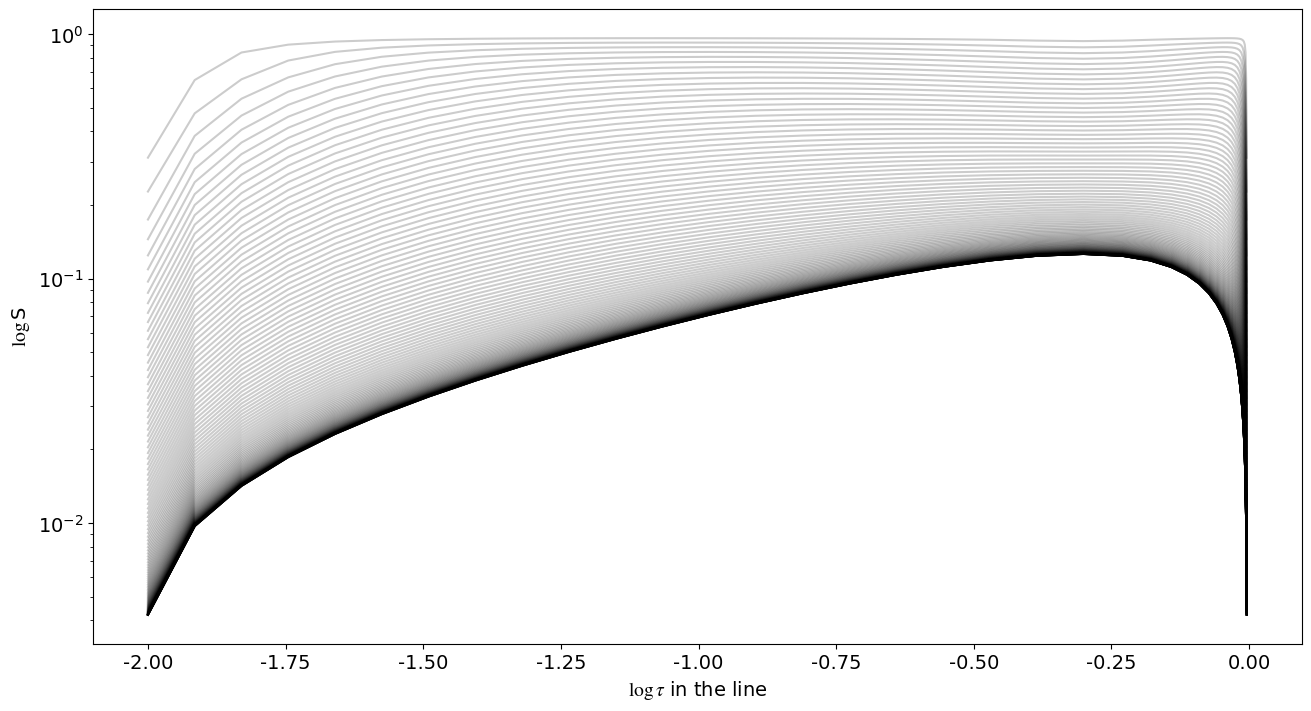

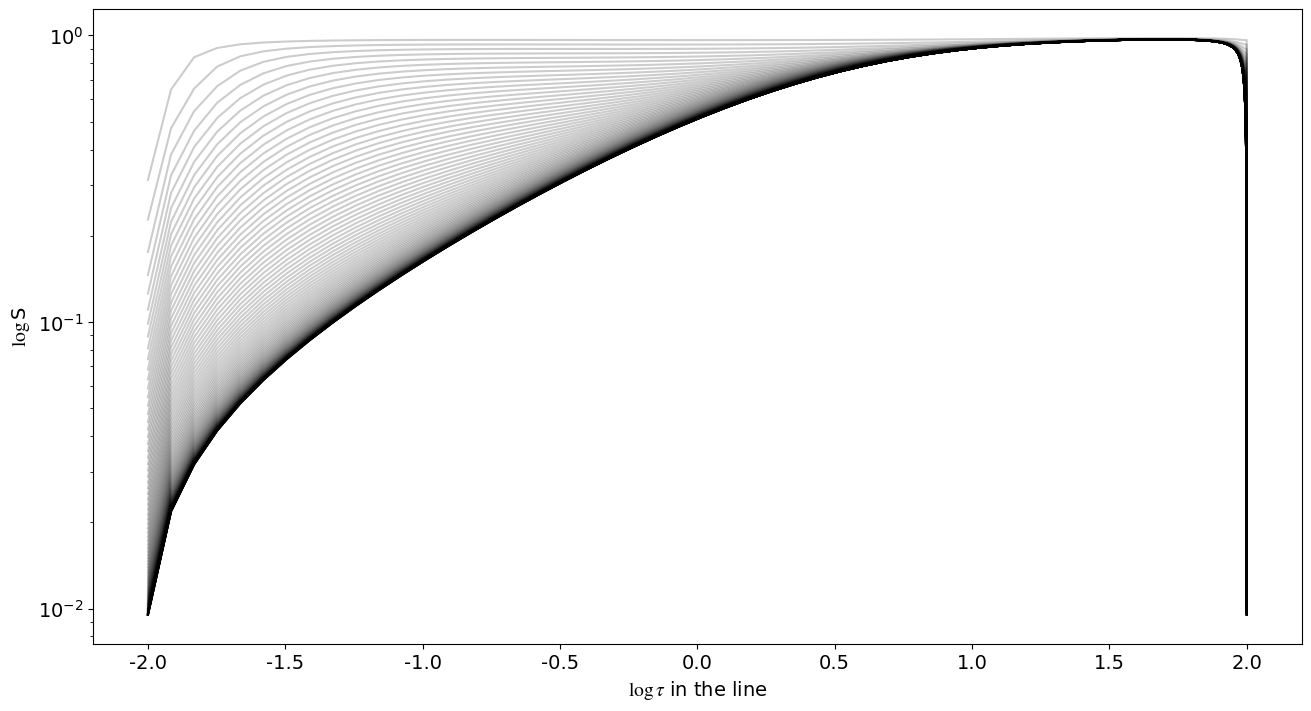

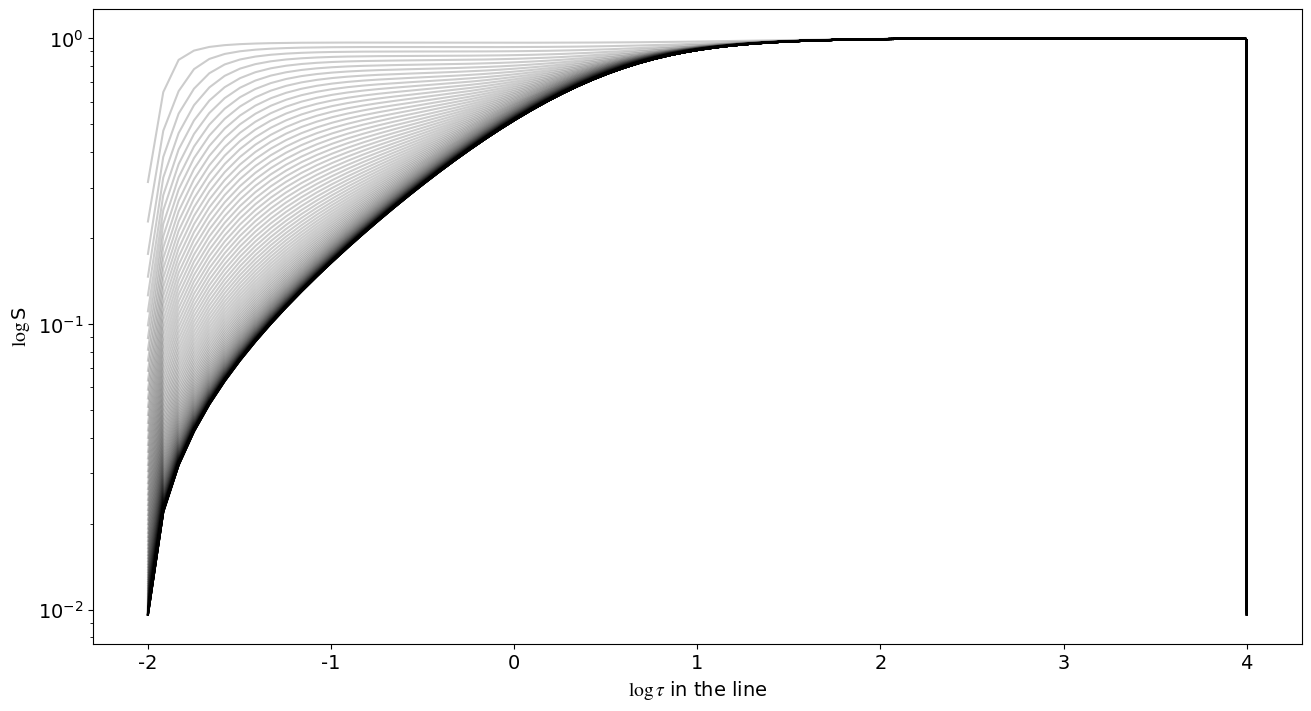

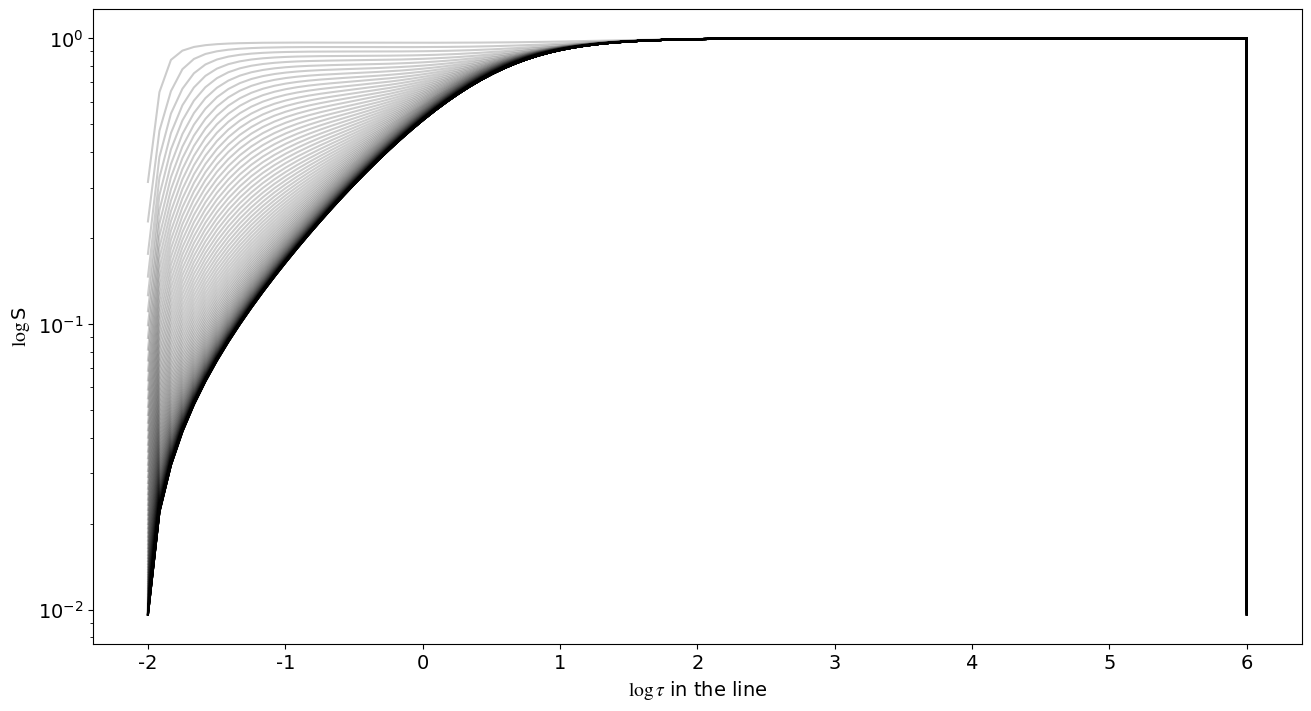

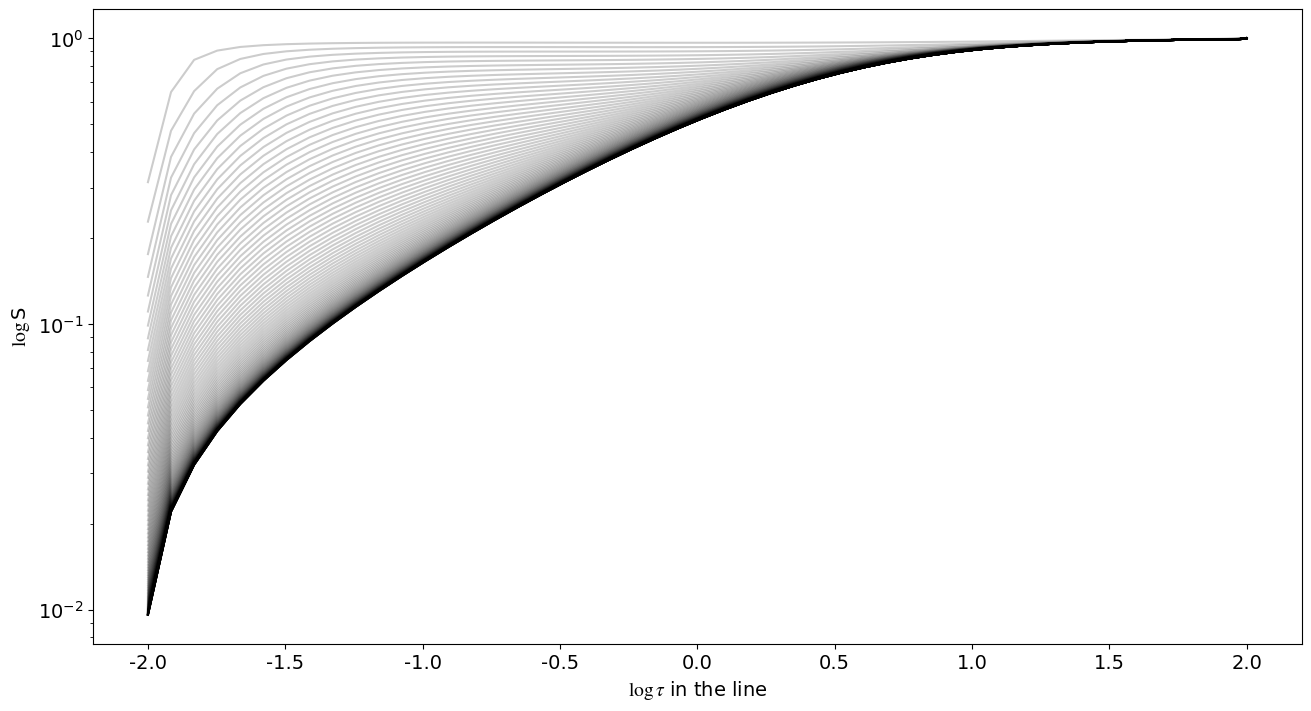

In [18]:
# How about intensity??
lratio = 1E3
x = np.linspace(-6, 6, 121)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))

tau2 = tau_grid(1E-2, 1, 12)
S_D_finite_e4_T2 = two_lvl_nlte_solver(tau2, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
#print(S_D_finite_e4_T2)
I_out2 = one_full_fs(tau2*lratio,S_D_finite_e4_T2,1.0,profile,S_D_finite_e4_T2[-1])

tau4 = tau_grid(1E-2, 1E2, 12)
S_D_finite_e4_T4 = two_lvl_nlte_solver(tau4, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out4 = one_full_fs(tau4*lratio,S_D_finite_e4_T4,1.0,profile,S_D_finite_e4_T4[-1])

tau6 = tau_grid(1E-2, 1E4, 12)
S_D_finite_e4_T6 = two_lvl_nlte_solver(tau6, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out6 = one_full_fs(tau6*lratio,S_D_finite_e4_T6,1.0,profile,S_D_finite_e4_T6[-1])

tau8 = tau_grid(1E-2, 1E6, 12)
S_D_finite_e4_T8 = two_lvl_nlte_solver(tau8, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out8 = one_full_fs(tau8*lratio,S_D_finite_e4_T8,1.0,profile,S_D_finite_e4_T8[-1])

taui = tau_grid(1E-2, 1E2, 12)
S_D_e4 = two_lvl_nlte_solver(taui, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
I_outinf = one_full_fs(taui*lratio,S_D_e4,1.0,profile,S_D_e4[-1])

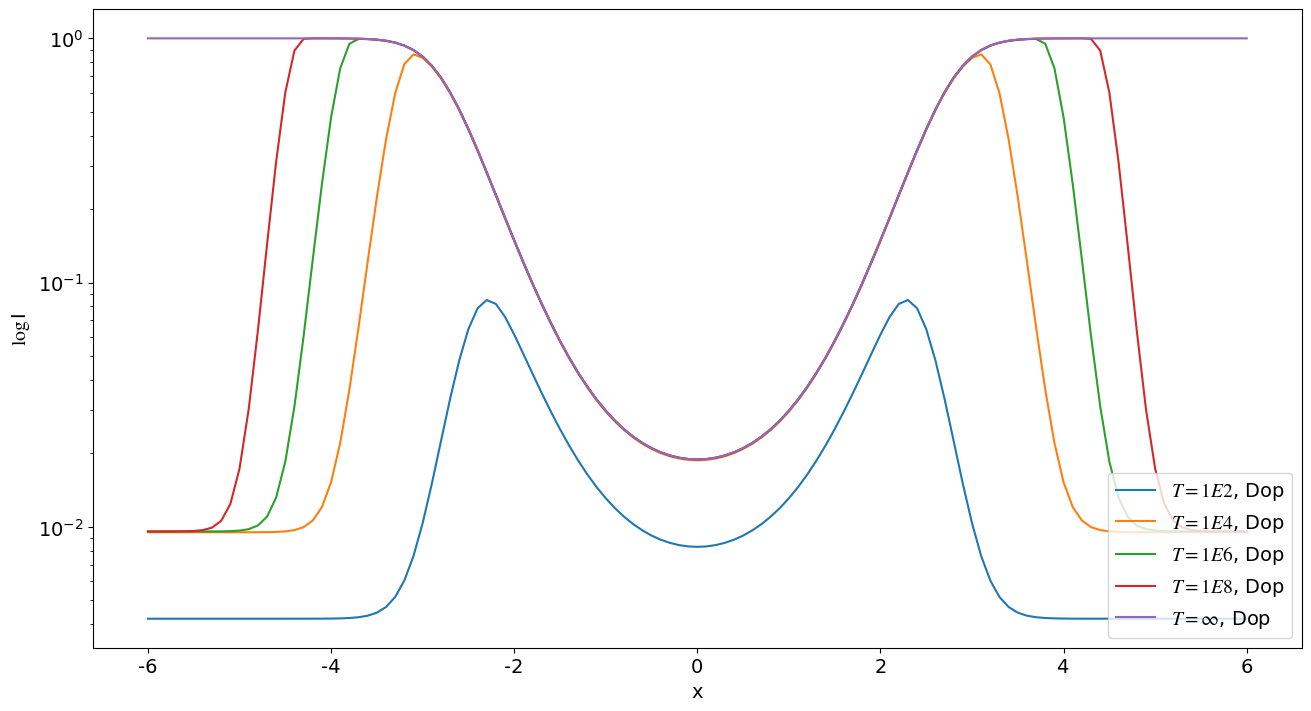

In [19]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("x")
#plt.xlim(0,5)
plt.ylabel("$\\log$I")
plt.semilogy(x, I_out2, label = "$T = 1E2$, Dop")
plt.semilogy(x, I_out4, label = "$T = 1E4$, Dop")
plt.semilogy(x, I_out6, label = "$T = 1E6$, Dop")
plt.semilogy(x, I_out8, label = "$T = 1E8$, Dop")
plt.semilogy(x, I_outinf, label = "$T = \infty$, Dop")
plt.legend(loc = "lower right", ncols = 1)

In [20]:
print(I_out6)

[0.00958173 0.00958174 0.00958175 0.00958178 0.00958187 0.00958214
 0.00958294 0.00958526 0.00959181 0.00960996 0.00965922 0.00979025
 0.01013169 0.01100313 0.0131803  0.01849761 0.03115277 0.06029326
 0.12417727 0.25291947 0.47438159 0.75426627 0.94964188 0.99454153
 0.99286938 0.98693215 0.97674655 0.96001008 0.93382872 0.89514401
 0.84162128 0.77283881 0.69119624 0.60180968 0.51119003 0.42538837
 0.3486273  0.28292004 0.22846774 0.18434512 0.14911378 0.12123162
 0.09927153 0.08201001 0.06844293 0.05776704 0.0493494  0.04269556
 0.03742125 0.03322878 0.02988808 0.02722178 0.02509343 0.02339832
 0.0220563  0.02100622 0.02020179 0.01960849 0.01920139 0.01896362
 0.01888543 0.01896362 0.01920139 0.01960849 0.02020179 0.02100622
 0.0220563  0.02339832 0.02509343 0.02722178 0.02988808 0.03322878
 0.03742125 0.04269556 0.0493494  0.05776704 0.06844293 0.08201001
 0.09927153 0.12123162 0.14911378 0.18434512 0.22846774 0.28292004
 0.3486273  0.42538837 0.51119003 0.60180968 0.69119624 0.7728

<h2><b>$\Lambda$-iteration</b></h2>

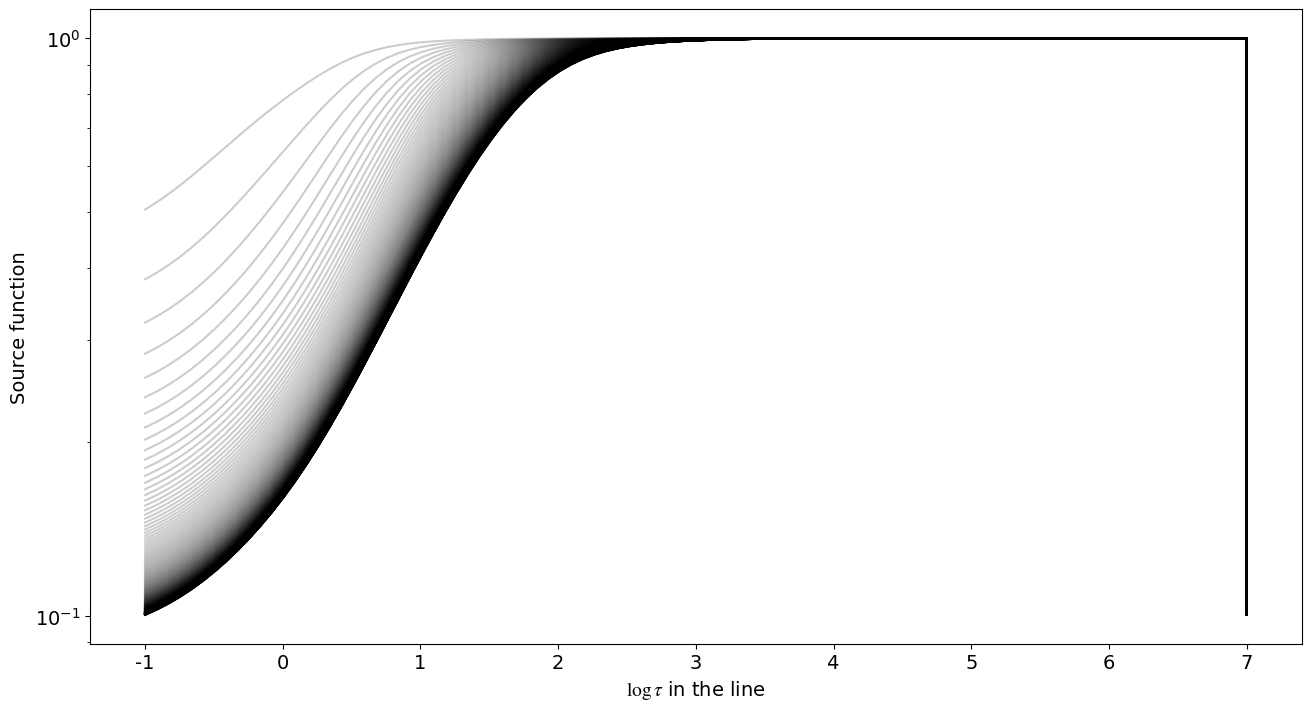

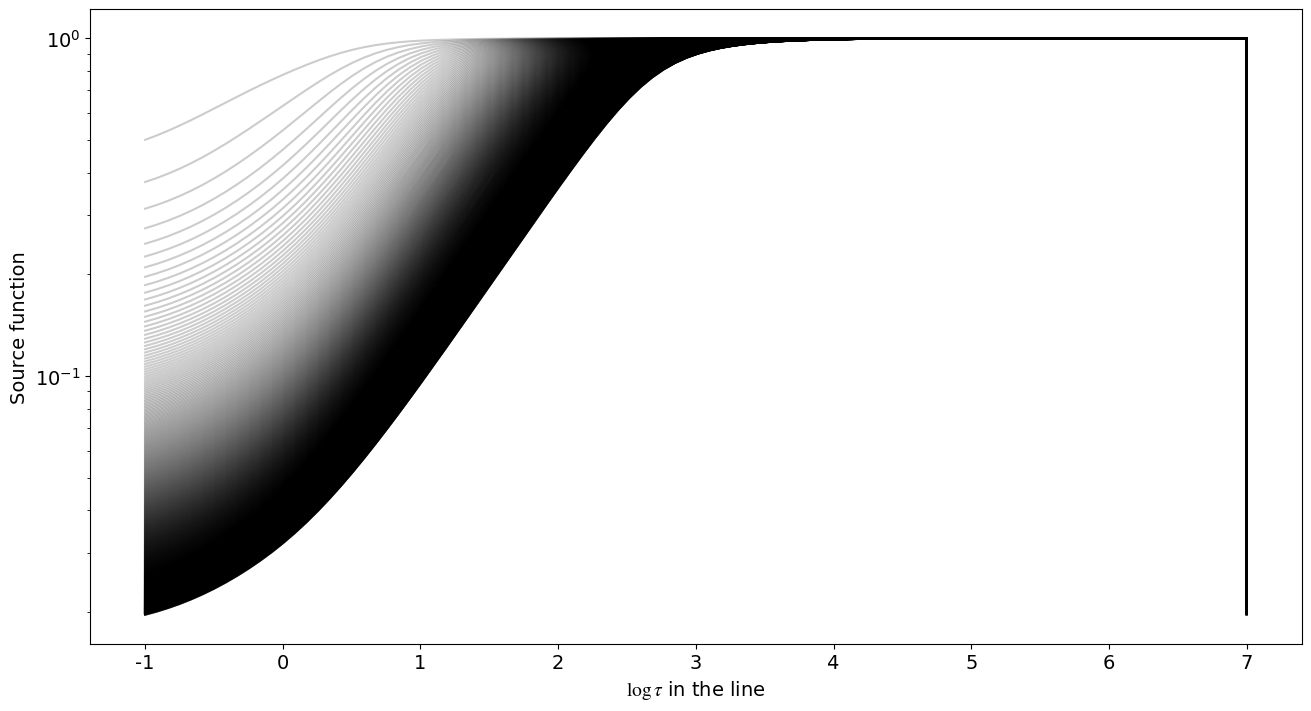

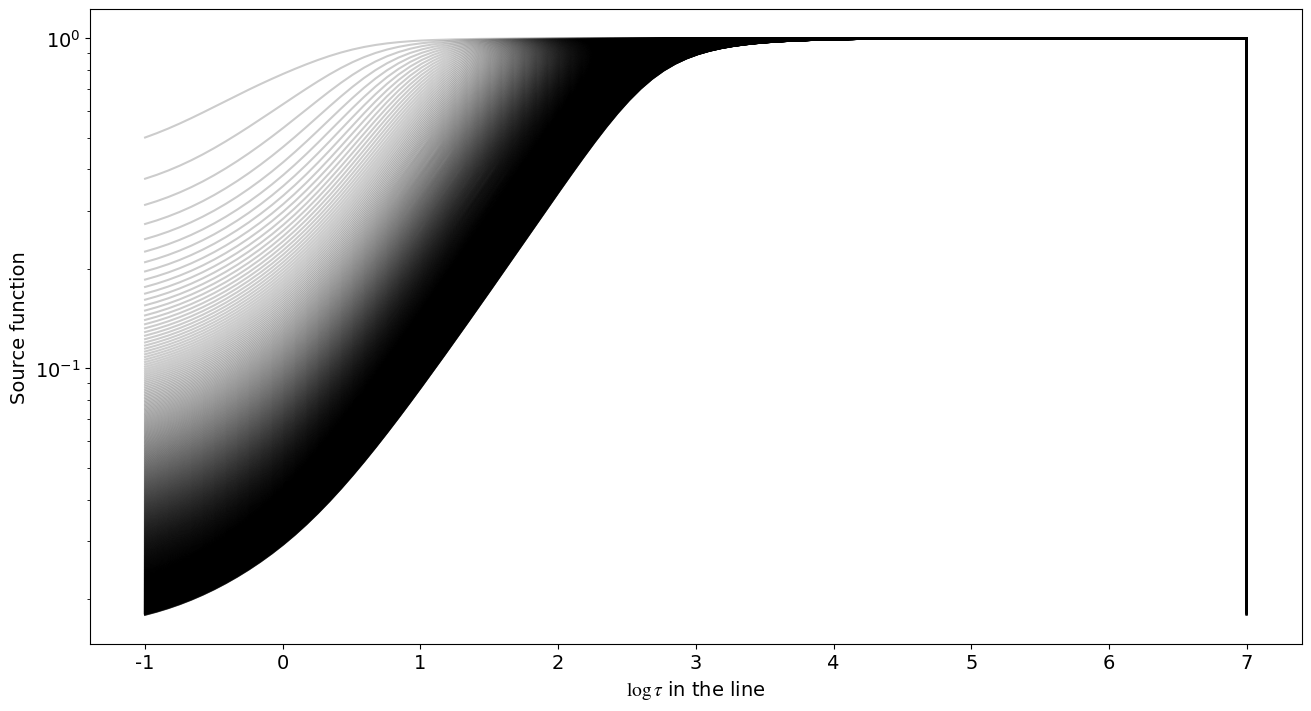

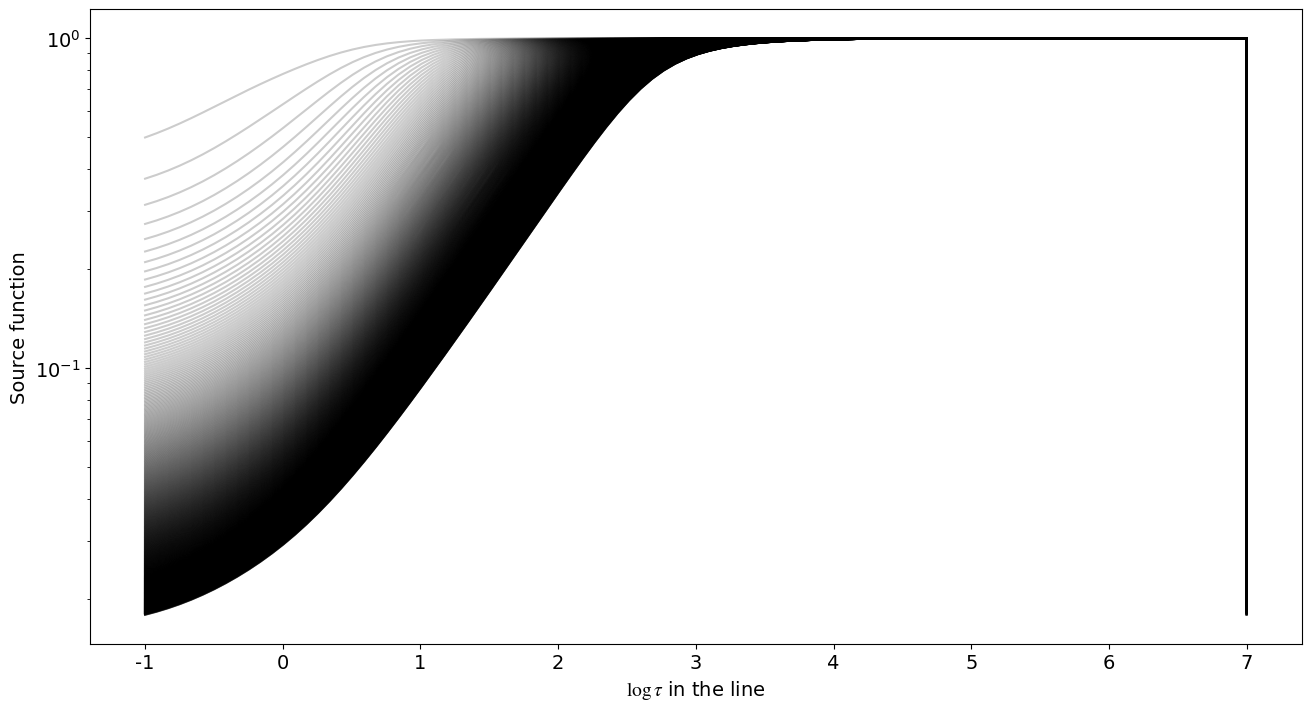

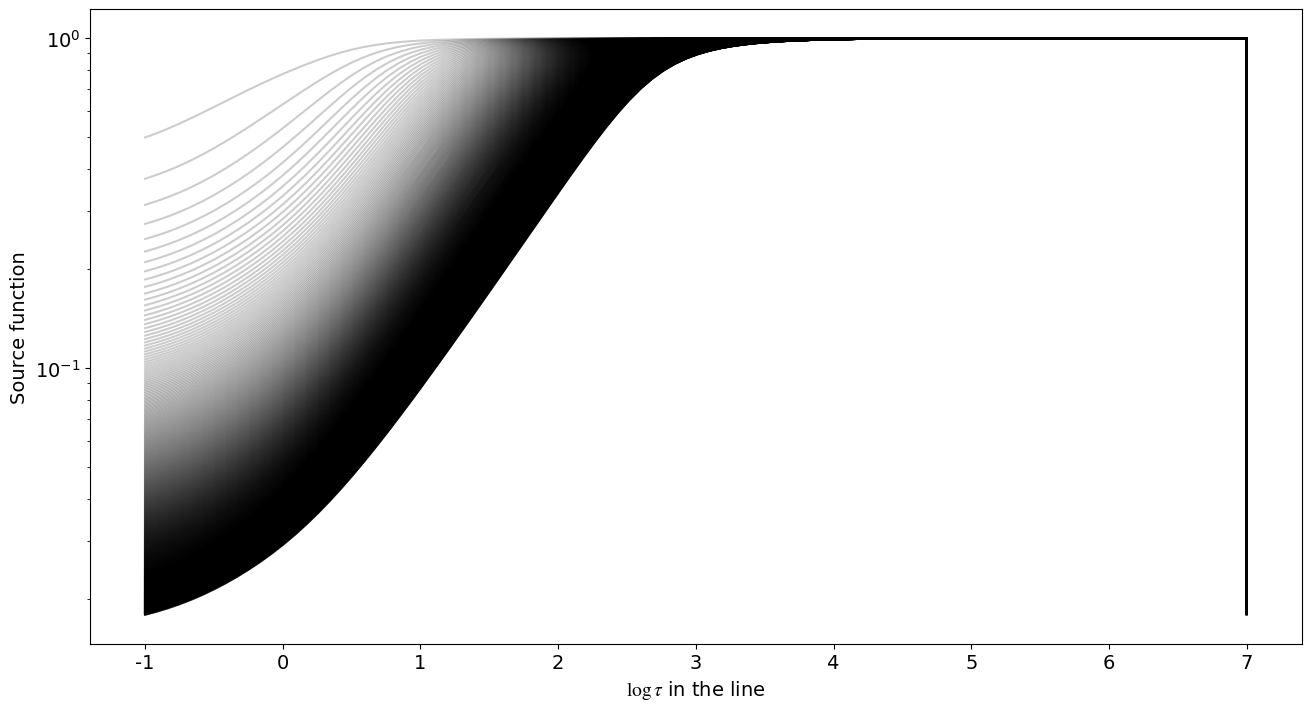

In [21]:
S_D_finite_e2_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-2, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e4_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e6_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-6, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e8_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-8, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e10_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-10, 1, low_bound = 0.0, up_bound = 0.0)

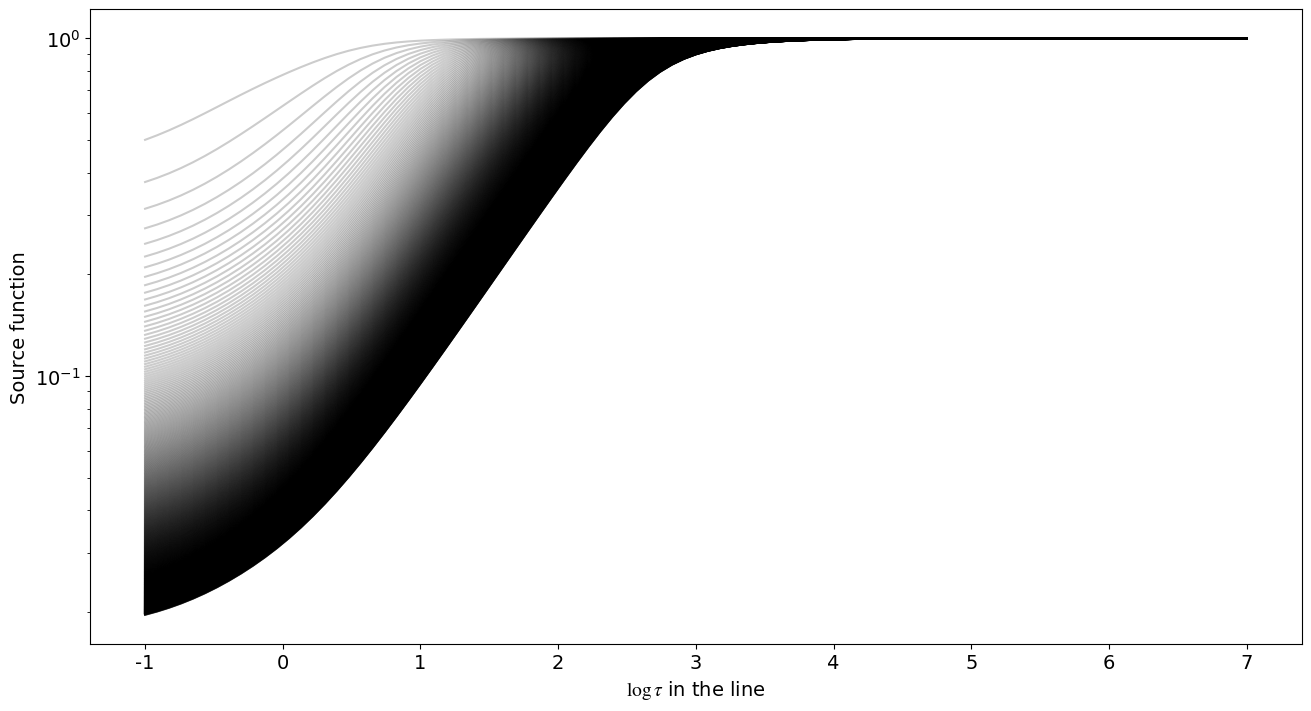

In [22]:
ltau_LI = np.linspace(-4, 4, 93)
tau_l_LI = 10**ltau_LI
S_D_e4_LI = two_level_atom_LI(tau_l_LI, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)

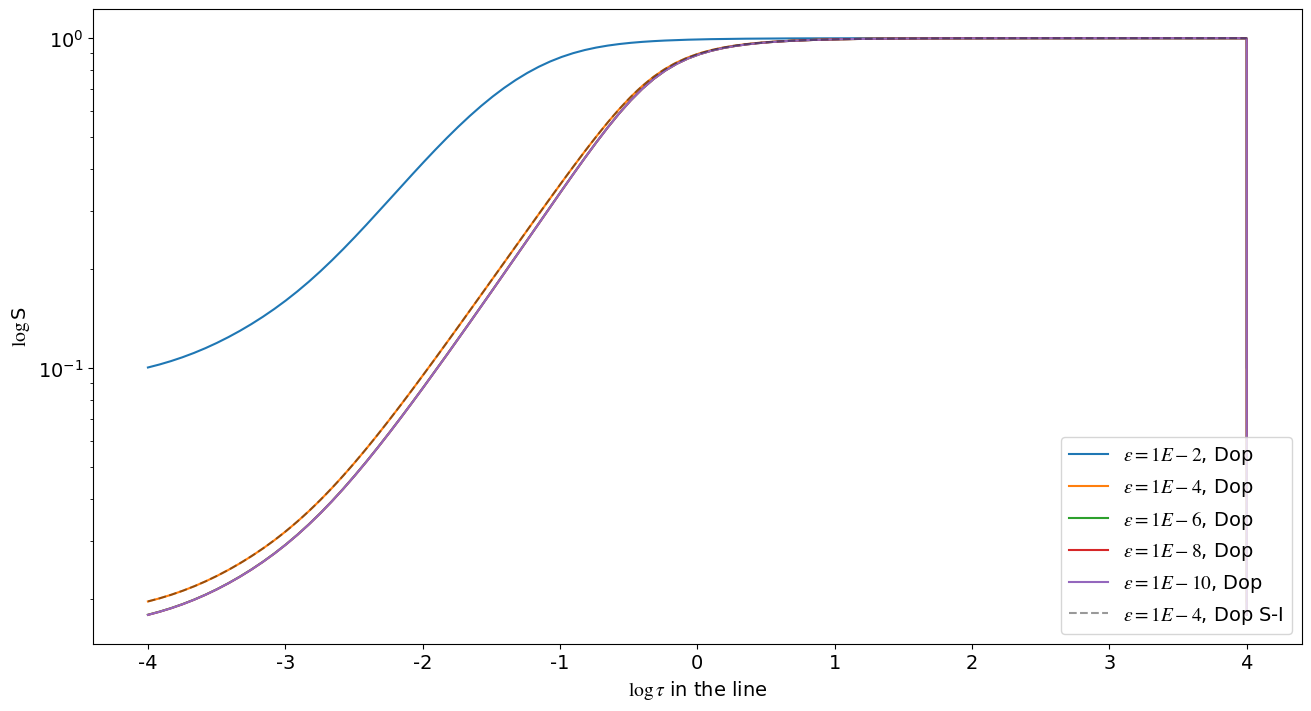

In [23]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau, S_D_finite_e2_T4_LI, label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau, S_D_finite_e4_T4_LI, label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau, S_D_finite_e6_T4_LI, label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau, S_D_finite_e8_T4_LI, label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau, S_D_finite_e10_T4_LI, label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(ltau, S_D_e4_LI, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

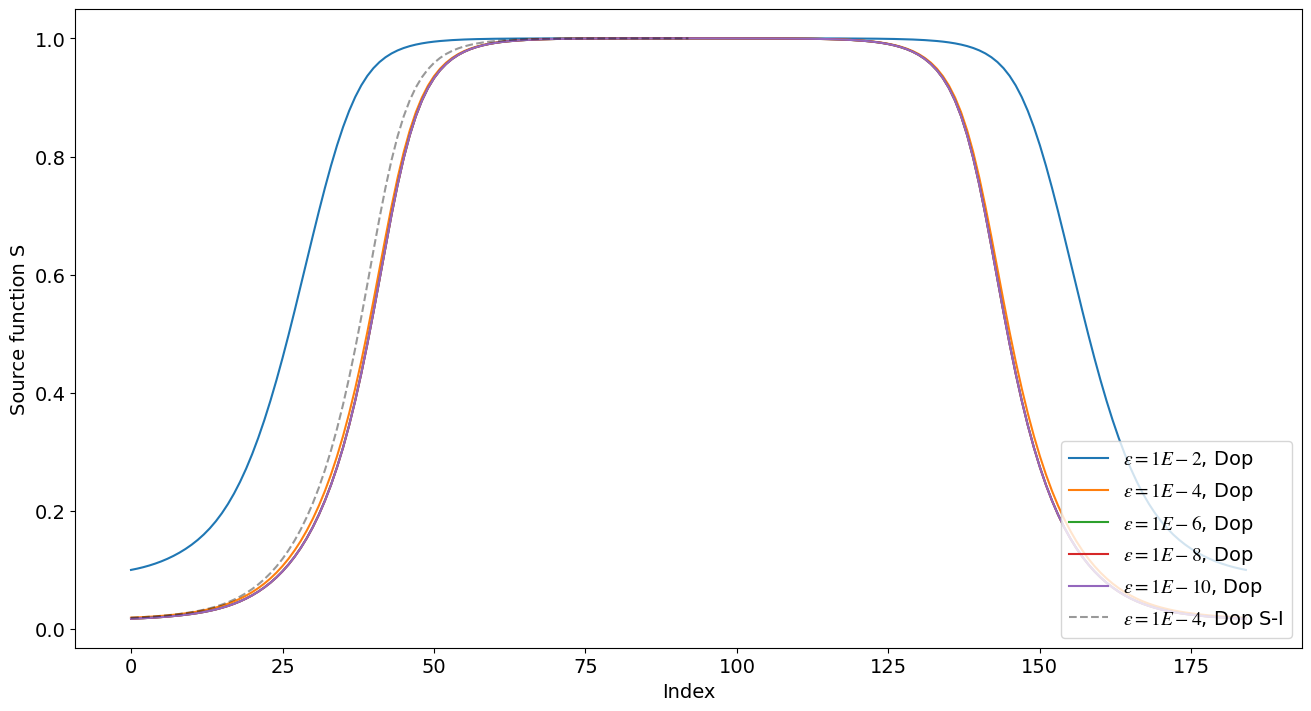

In [24]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("Index")
plt.ylabel("Source function S")
plt.plot(S_D_finite_e2_T4_LI, label = "$\\varepsilon = 1E-2$, Dop")
plt.plot(S_D_finite_e4_T4_LI, label = "$\\varepsilon = 1E-4$, Dop")
plt.plot(S_D_finite_e6_T4_LI, label = "$\\varepsilon = 1E-6$, Dop")
plt.plot(S_D_finite_e8_T4_LI, label = "$\\varepsilon = 1E-8$, Dop")
plt.plot(S_D_finite_e10_T4_LI, label = "$\\varepsilon = 1E-10$, Dop")
plt.plot(S_D_e4_LI, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

In [25]:
S_D_finite_e6_T4_LI_diff = element_difference(S_D_finite_e6_T4_LI)
print(S_D_finite_e6_T4_LI_diff)

[-3.33413852e-15  3.33413852e-15 -7.56662441e-12 -1.36115945e-11
 -5.57438123e-12 -2.16122363e-11 -3.84244025e-12 -1.46867588e-12
 -2.99378577e-14 -3.64676692e-12 -5.06521908e-12  5.15282261e-14
 -1.36805636e-11 -1.76218970e-11 -4.25588037e-12 -5.09647879e-12
 -3.37459921e-12 -2.09488676e-12 -3.35580175e-12 -8.84957385e-12
 -9.41587086e-12 -9.30094196e-12 -7.84038112e-12 -9.18845555e-12
 -6.99613978e-12 -4.66154892e-13 -3.53304885e-12 -9.33517152e-12
 -5.20698762e-12 -4.80282480e-13 -6.01979577e-12 -4.80668283e-12
 -4.12539447e-12 -3.68094444e-12 -4.38390990e-12 -3.34116068e-12
 -7.29249994e-13 -2.88691293e-12 -2.40629738e-12 -1.44739776e-12
 -1.29973809e-12 -1.64213088e-12 -9.49129664e-13 -4.72621942e-13
 -3.73590048e-13 -7.63056285e-13 -1.16573418e-14 -1.81632487e-13
 -2.79776202e-13 -4.61852778e-14  2.77555756e-15 -3.34177130e-14
 -5.25135491e-14 -2.58681965e-14 -2.95319325e-14 -1.67643677e-14
 -2.06501483e-14 -3.99680289e-15 -1.34336986e-14  1.33226763e-15
  7.99360578e-15 -2.22044

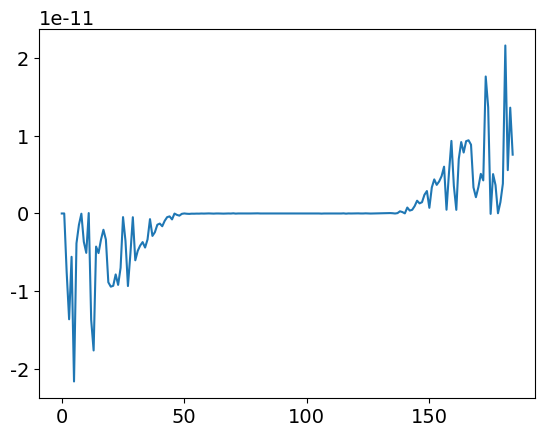

In [26]:
plt.plot(S_D_finite_e6_T4_LI_diff)

2.0
1.6989700043360187
21
0.08494850021680093
[0.01       0.01216042 0.01478758 0.01798231 0.02186724 0.02659148
 0.03233635 0.03932235 0.04781762 0.05814823 0.07071068 0.08598714
 0.10456396 0.12715414 0.15462475 0.18803015 0.22865253 0.27805103
 0.33812167 0.41117008 0.5        0.58882992 0.66187833 0.72194897
 0.77134747 0.81196985 0.84537525 0.87284586 0.89543604 0.91401286
 0.92928932 0.94185177 0.95218238 0.96067765 0.96766365 0.97340852
 0.97813276 0.98201769 0.98521242 0.98783958 0.99      ]
4.0
3.6989700043360187
45
0.08406750009854588
[1.00000000e-02 1.21357746e-02 1.47277024e-02 1.78732076e-02
 2.16905218e-02 2.63231283e-02 3.19451551e-02 3.87679200e-02
 4.70478737e-02 5.70962389e-02 6.92907083e-02 8.40896415e-02
 1.02049293e-01 1.23844722e-01 1.50295162e-01 1.82394821e-01
 2.21350242e-01 2.68625664e-01 3.25998050e-01 3.95623884e-01
 4.80120226e-01 5.82663082e-01 7.07106781e-01 8.58128848e-01
 1.04140582e+00 1.26382663e+00 1.53375151e+00 1.86132625e+00
 2.25886358e+00 2.7413

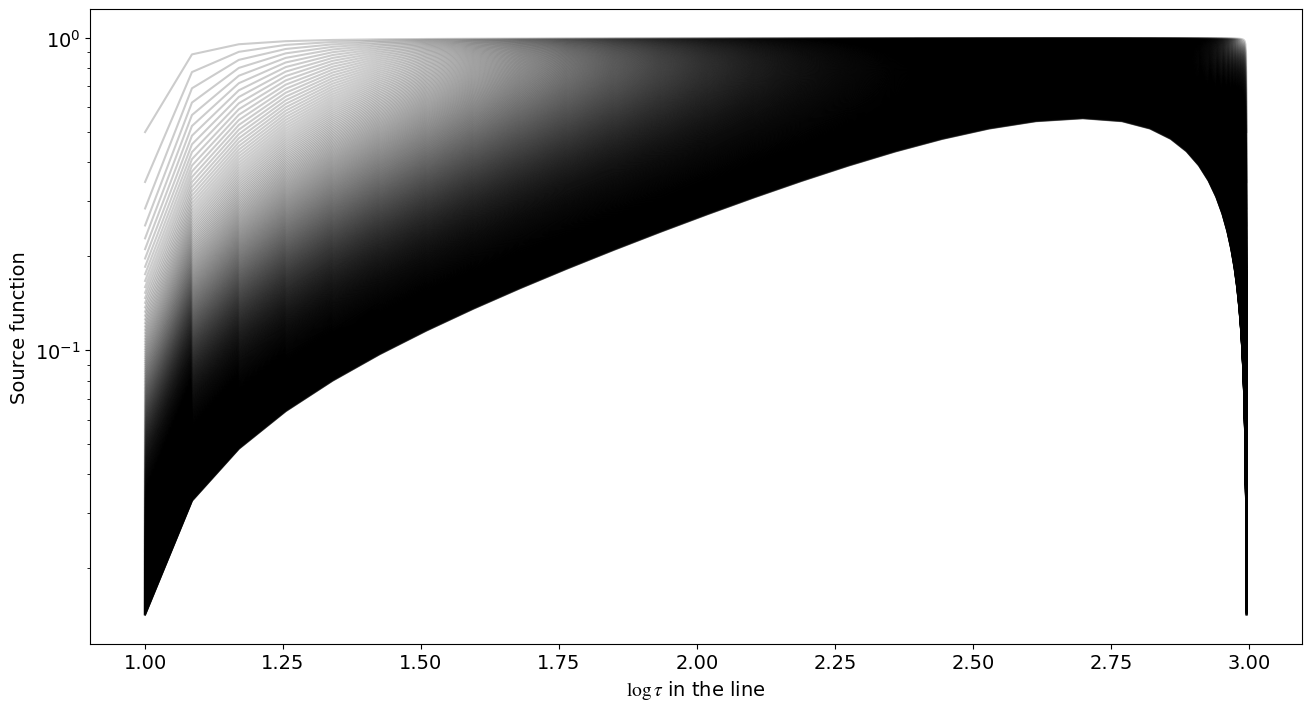

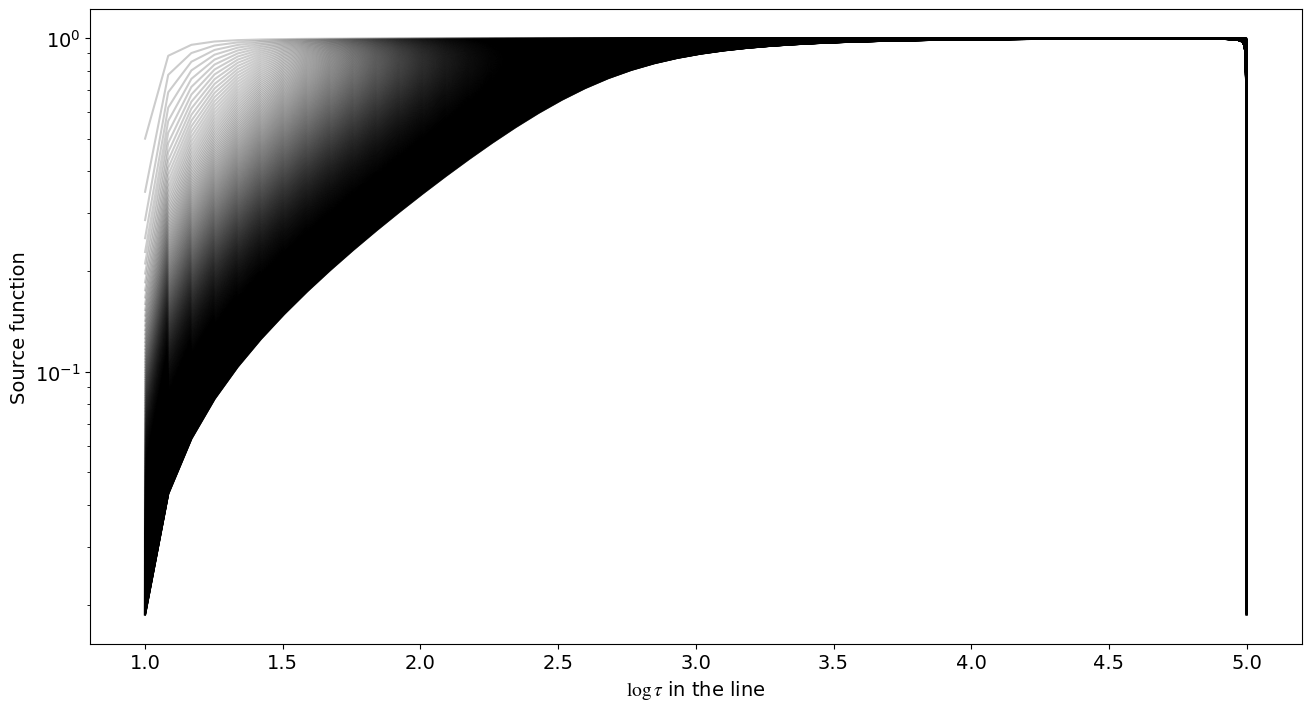

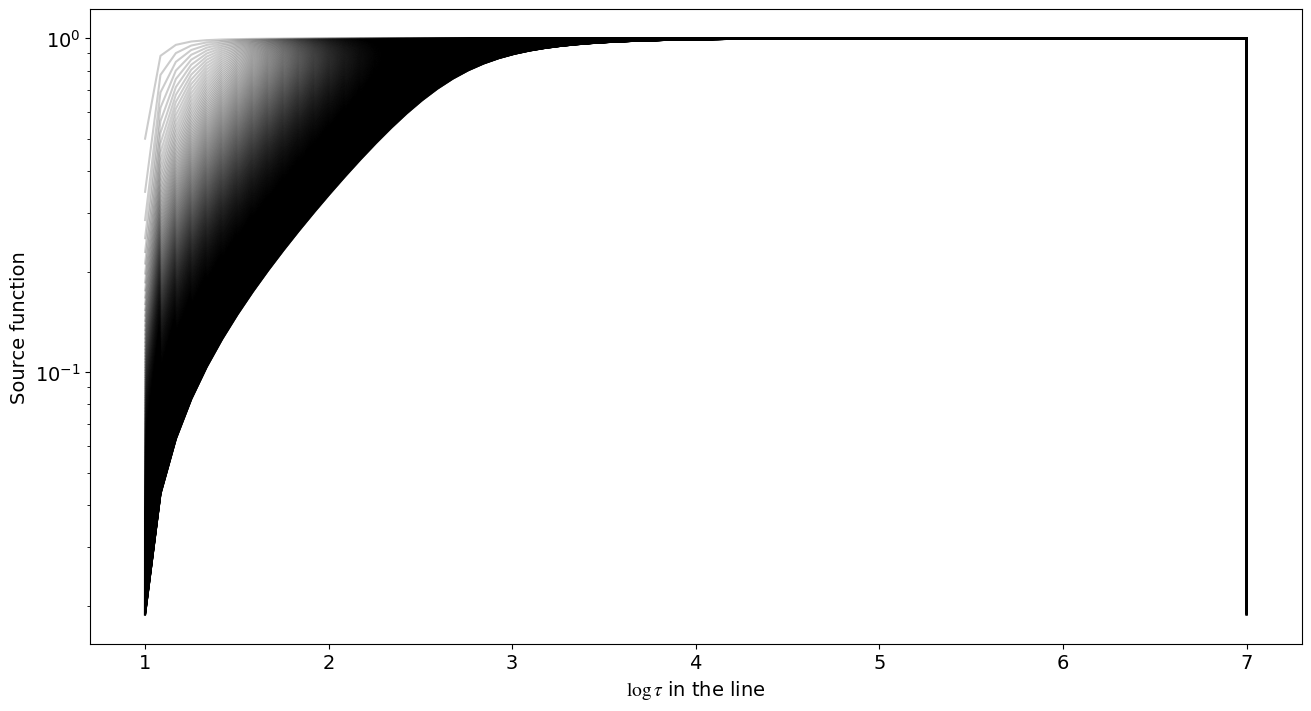

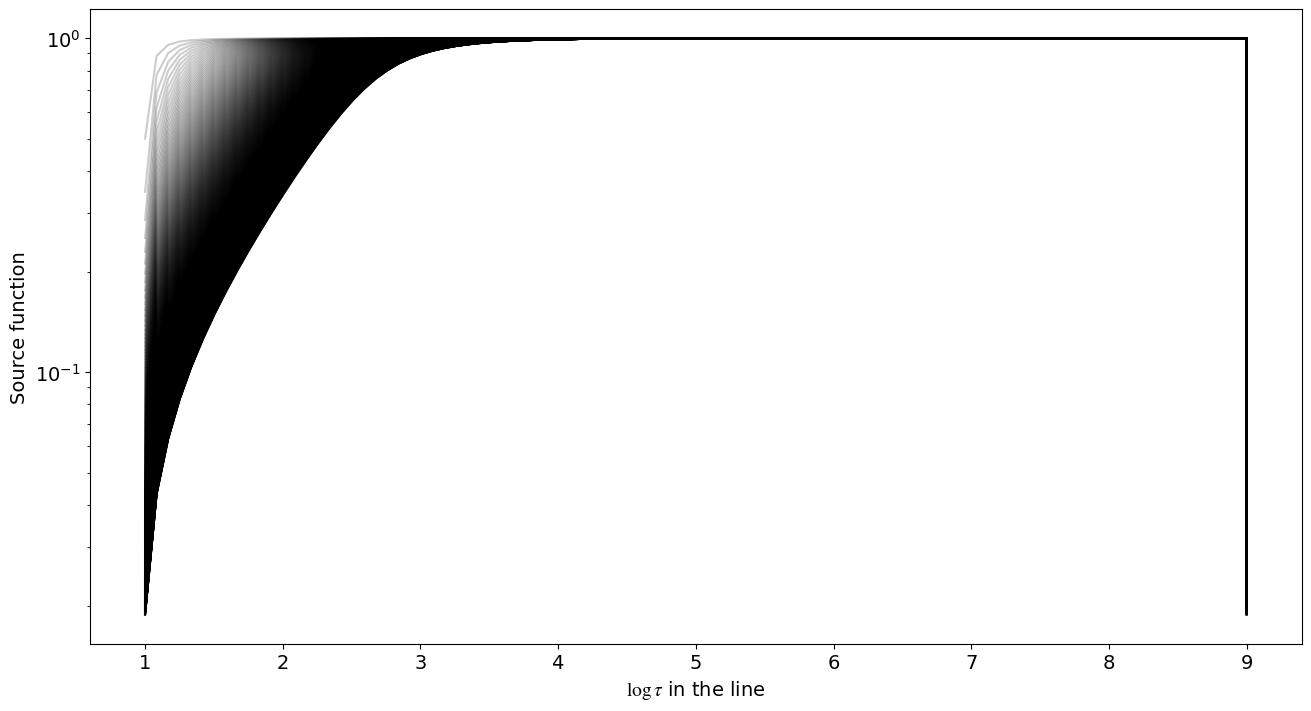

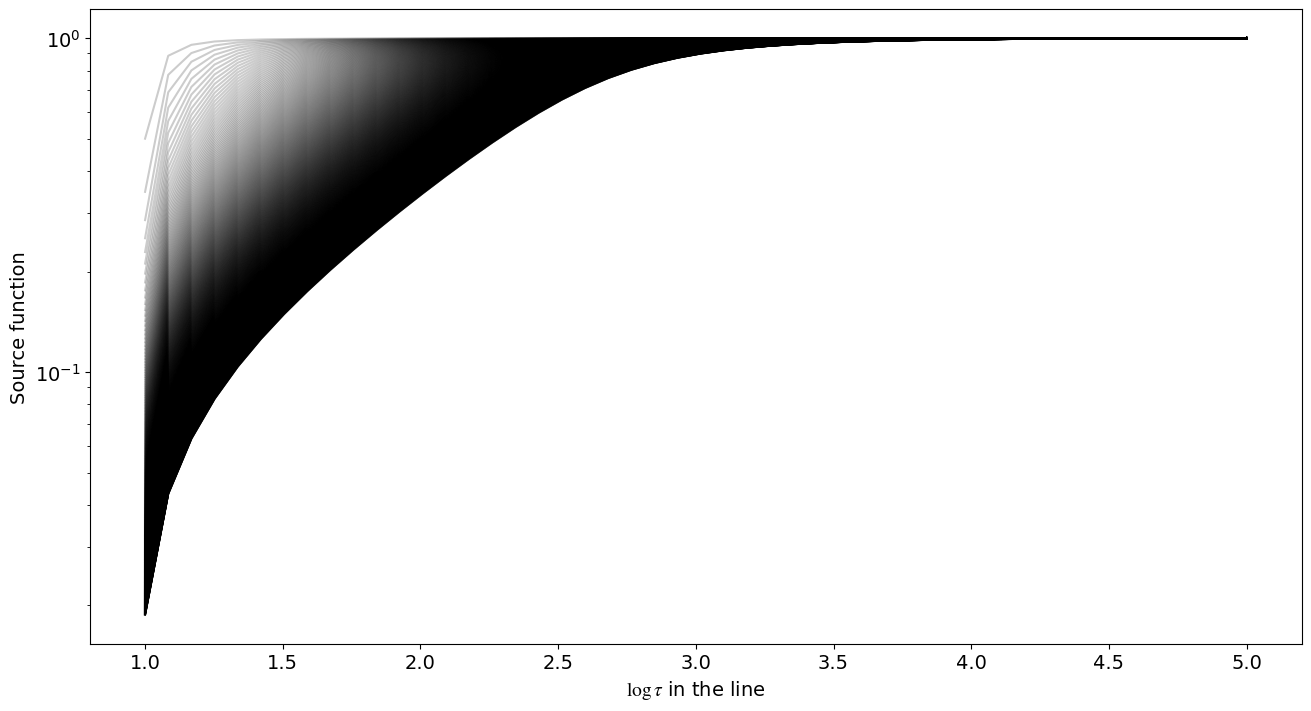

In [27]:
# How about intensity??
lratio = 1E3
x = np.linspace(-6, 6, 121)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))

tau2 = tau_grid(1E-2, 1, 12)
S_D_finite_e4_T2_LI = two_level_atom_LI(tau2, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
#print(S_D_finite_e4_T2)
I_out2_LI = one_full_fs(tau2*lratio,S_D_finite_e4_T2_LI,1.0,profile,S_D_finite_e4_T2_LI[-1])

tau4 = tau_grid(1E-2, 1E2, 12)
S_D_finite_e4_T4_LI = two_level_atom_LI(tau4, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out4_LI = one_full_fs(tau4*lratio,S_D_finite_e4_T4_LI,1.0,profile,S_D_finite_e4_T4_LI[-1])

tau6 = tau_grid(1E-2, 1E4, 12)
S_D_finite_e4_T6_LI = two_level_atom_LI(tau6, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out6_LI = one_full_fs(tau6*lratio,S_D_finite_e4_T6_LI,1.0,profile,S_D_finite_e4_T6_LI[-1])

tau8 = tau_grid(1E-2, 1E6, 12)
S_D_finite_e4_T8_LI = two_level_atom_LI(tau8, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out8_LI = one_full_fs(tau8*lratio,S_D_finite_e4_T8_LI,1.0,profile,S_D_finite_e4_T8_LI[-1])

taui = tau_grid(1E-2, 1E2, 12)
S_D_e4_LI = two_level_atom_LI(taui, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
I_outinf_LI = one_full_fs(taui*lratio,S_D_e4_LI,1.0,profile,S_D_e4_LI[-1])

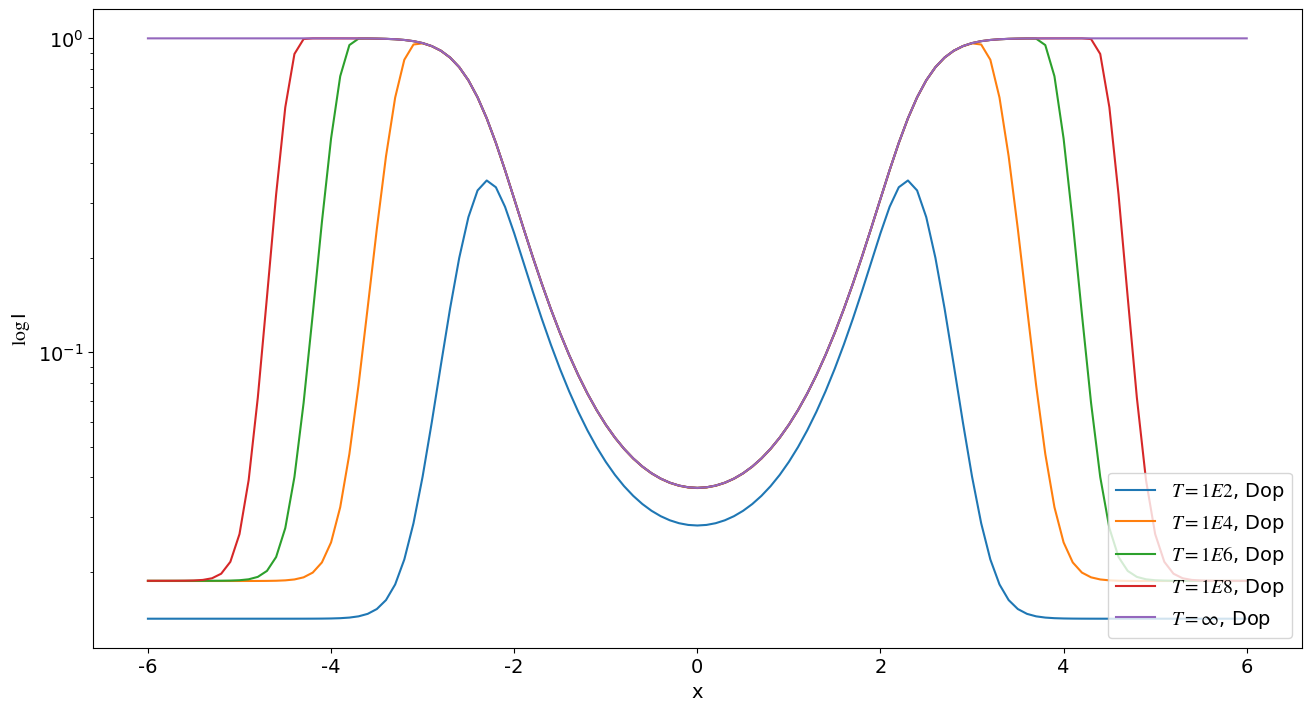

In [28]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("x")
#plt.xlim(0,5)
plt.ylabel("$\\log$I")
plt.semilogy(x, I_out2_LI, label = "$T = 1E2$, Dop")
plt.semilogy(x, I_out4_LI, label = "$T = 1E4$, Dop")
plt.semilogy(x, I_out6_LI, label = "$T = 1E6$, Dop")
plt.semilogy(x, I_out8_LI, label = "$T = 1E8$, Dop")
plt.semilogy(x, I_outinf_LI, label = "$T = \infty$, Dop")
plt.legend(loc = "lower right", ncols = 1)

<h2>Semi-infinite atmosphere</h2>
<p>Just to be sure, we also want to be able to recover the semi-infinite atmosphere case, i.e. <b><i>Fig. 11.1</i></b> and <b><i>Fig. 11.2</i></b>.</p>

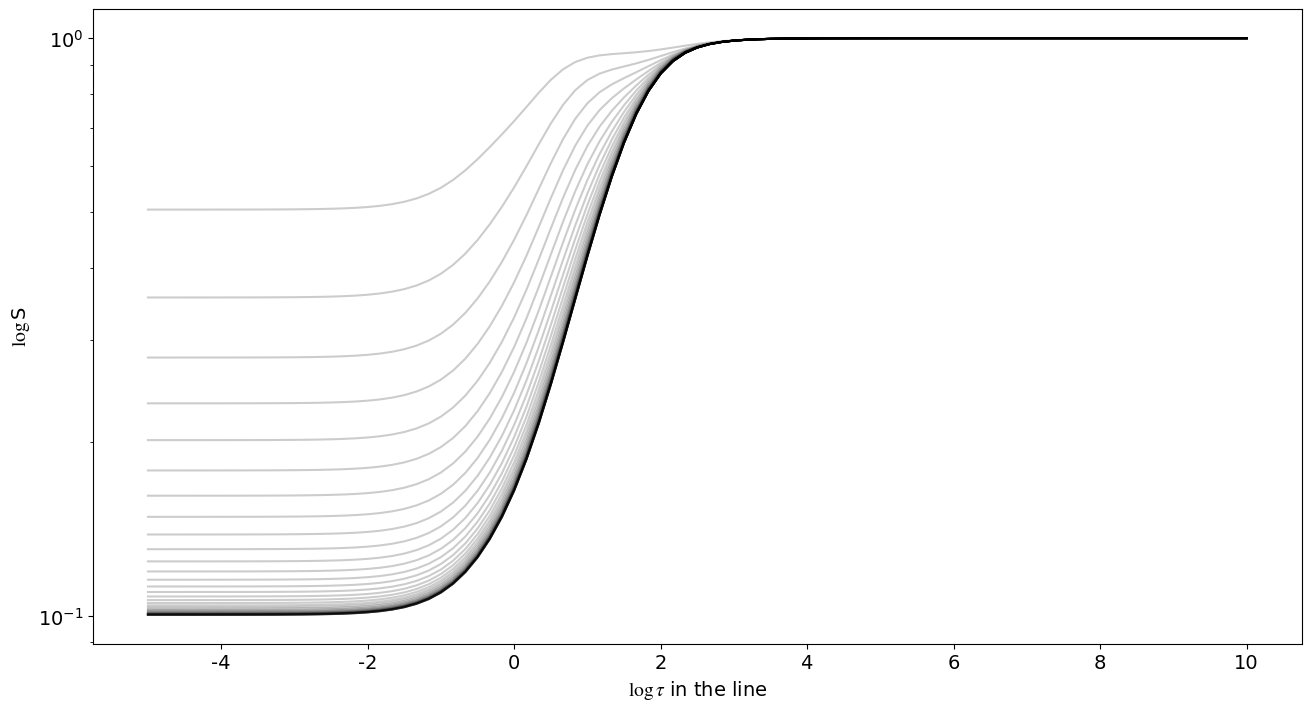

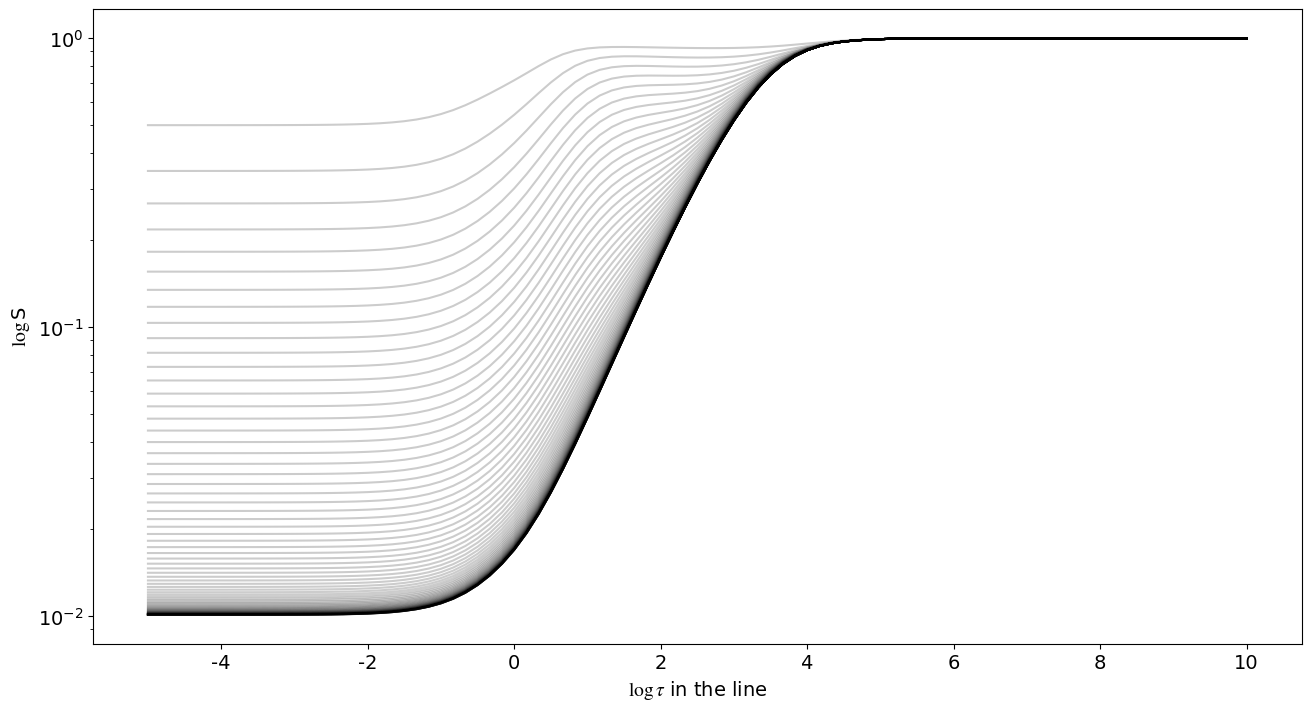

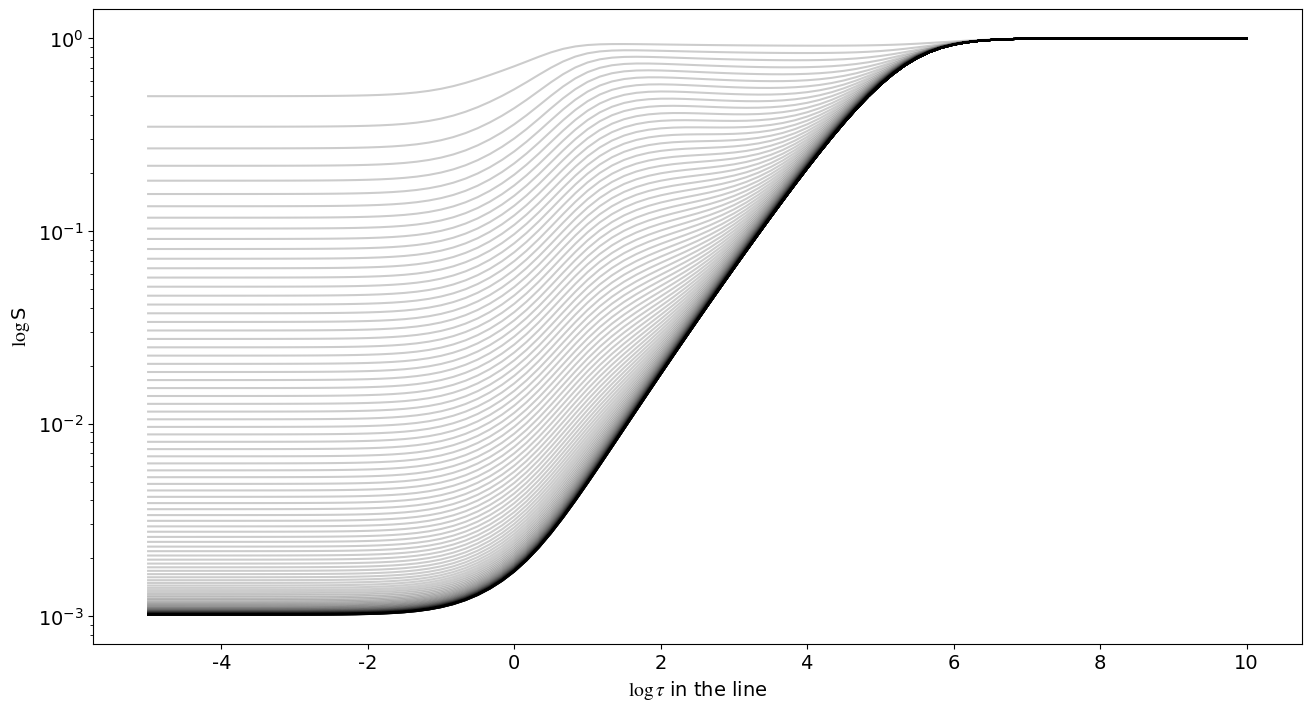

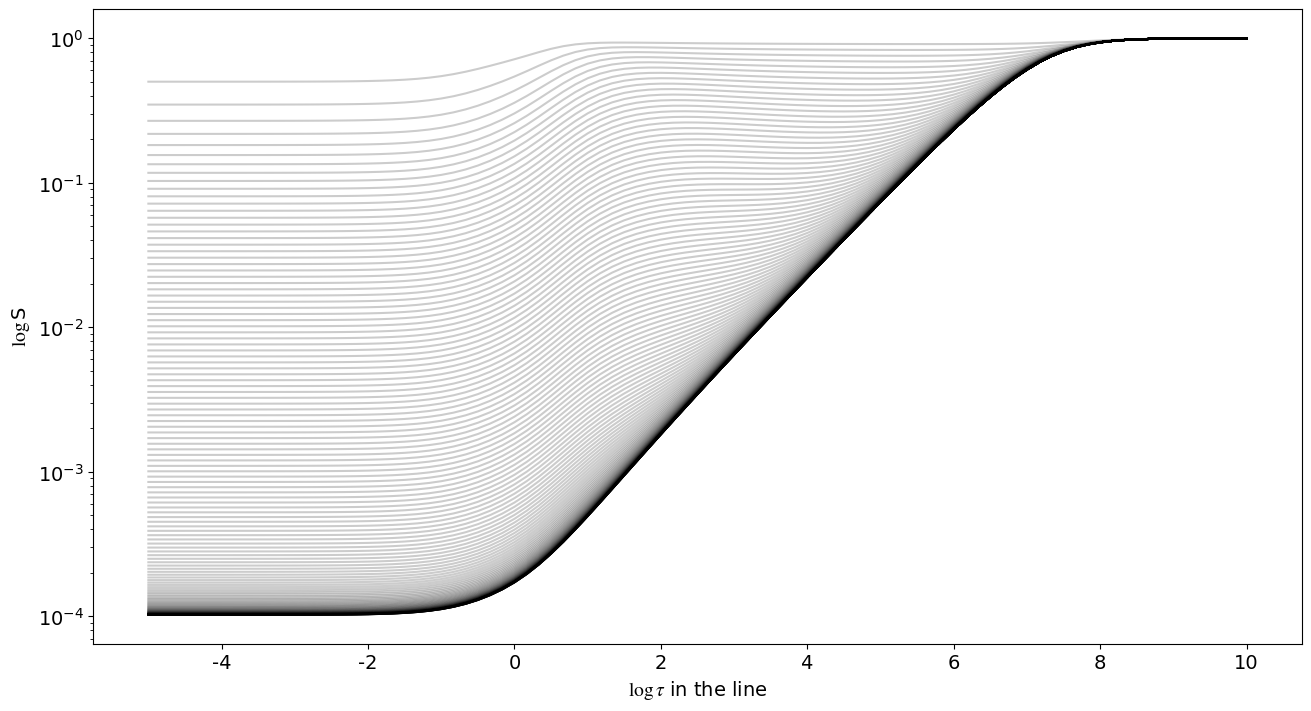

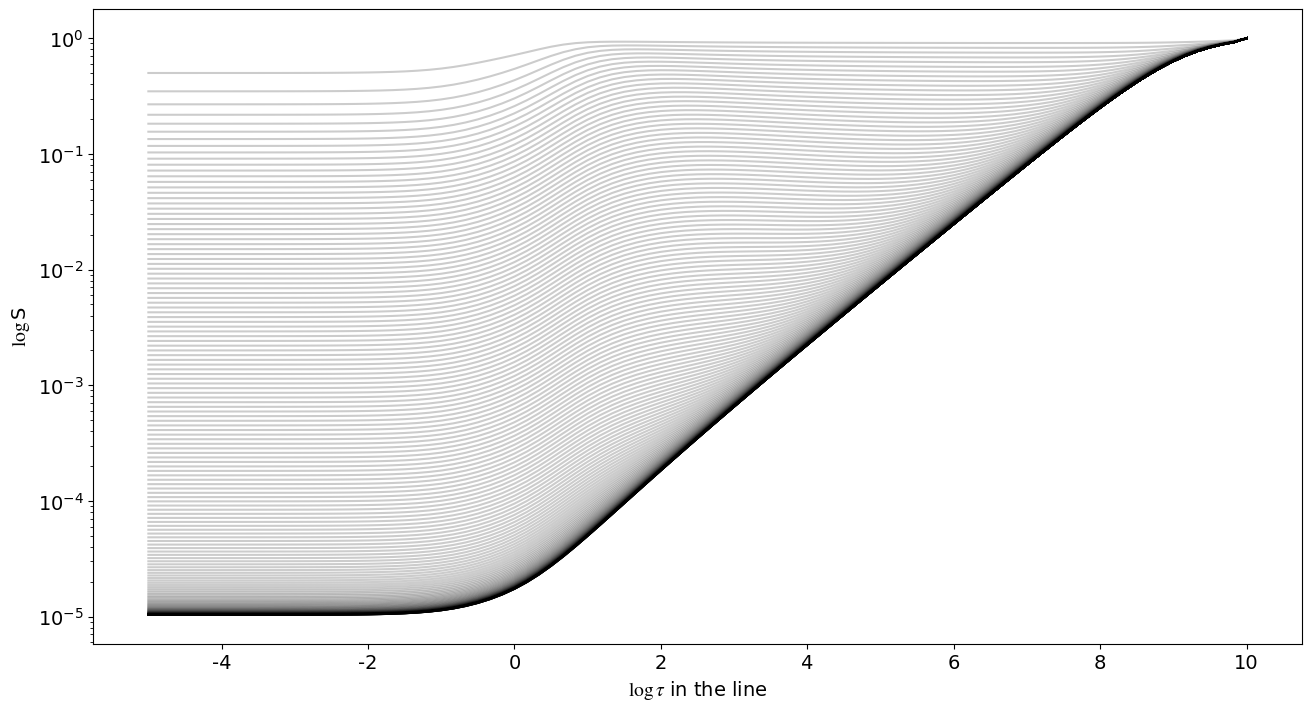

In [29]:
logtau_mock = np.linspace(-5, 10, 91)
tau_mock = 10**logtau_mock
#tau_mock = tau_grid(1E-2, 1E7, 12)
#logtau_mock = np.log10(tau_mock)
S_mock2 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-2, 1, low_bound = 1.0, up_bound = 0.0)
S_mock4 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)
S_mock6 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0)
S_mock8 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-8, 1, low_bound = 1.0, up_bound = 0.0)
S_mock10 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-10, 1, low_bound = 1.0, up_bound = 0.0)

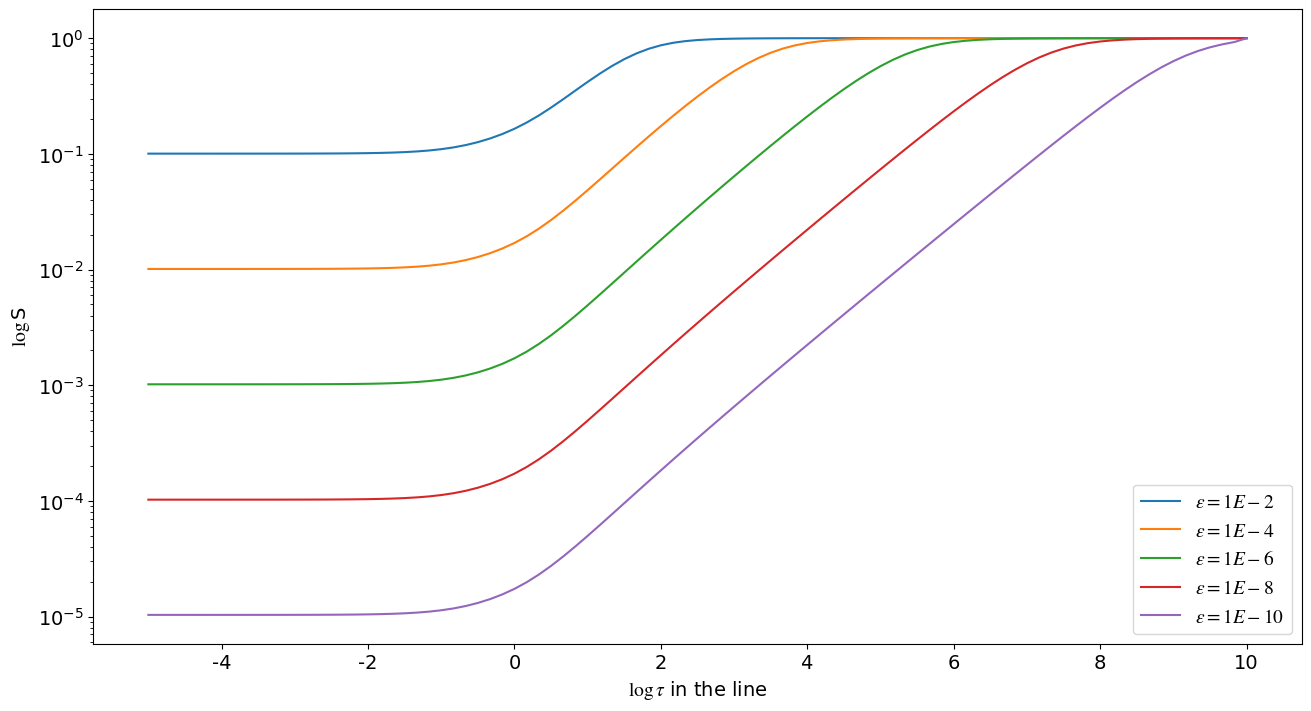

In [30]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau_mock, S_mock2, label = "$\\varepsilon = 1E-2$")
plt.semilogy(logtau_mock, S_mock4, label = "$\\varepsilon = 1E-4$")
plt.semilogy(logtau_mock, S_mock6, label = "$\\varepsilon = 1E-6$")
plt.semilogy(logtau_mock, S_mock8, label = "$\\varepsilon = 1E-8$")
plt.semilogy(logtau_mock, S_mock10, label = "$\\varepsilon = 1E-10$")
plt.legend()

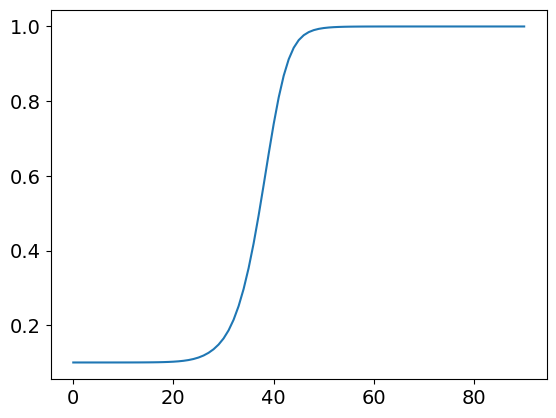

In [31]:
plt.plot(S_mock2)

<h3>What if we change line_ratio (lratio)??</h3>
<p>Here we want to see the impact of line_ratio parameter on the source function. Our goal is to reproduce <b><i>Fig. 11.5</i></b>
from Mihalas.</p>

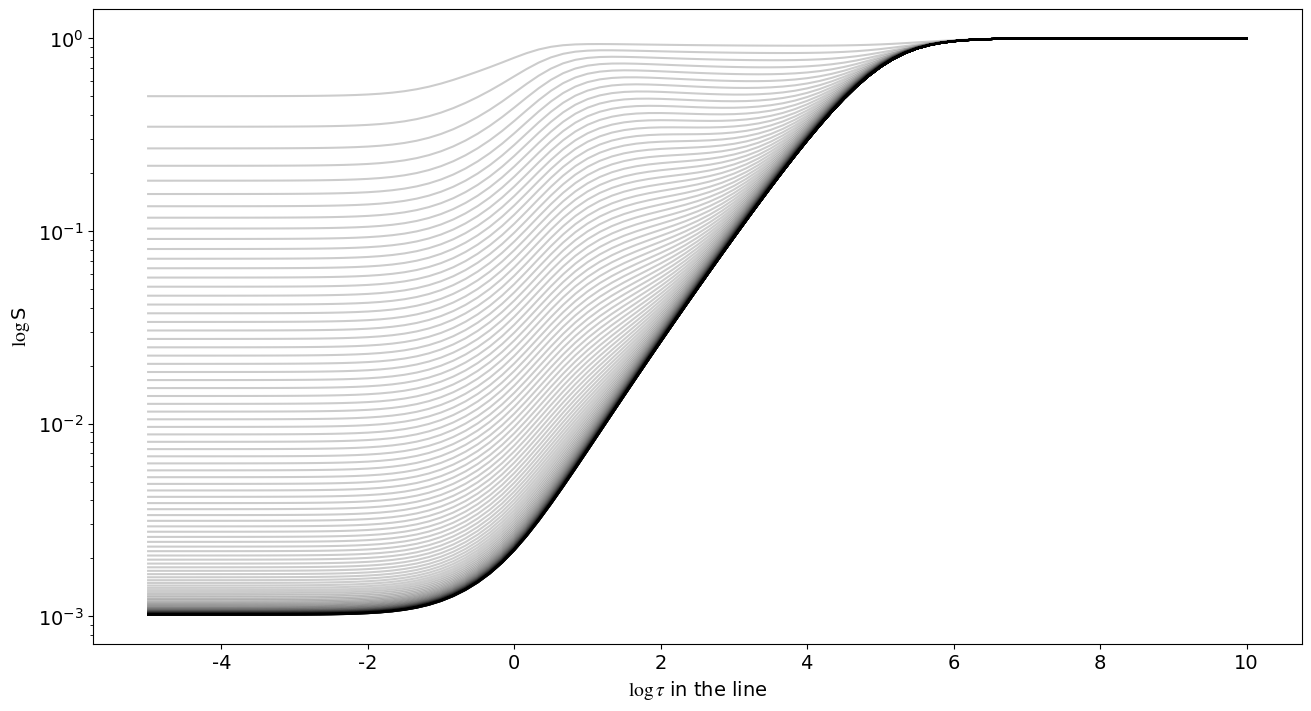

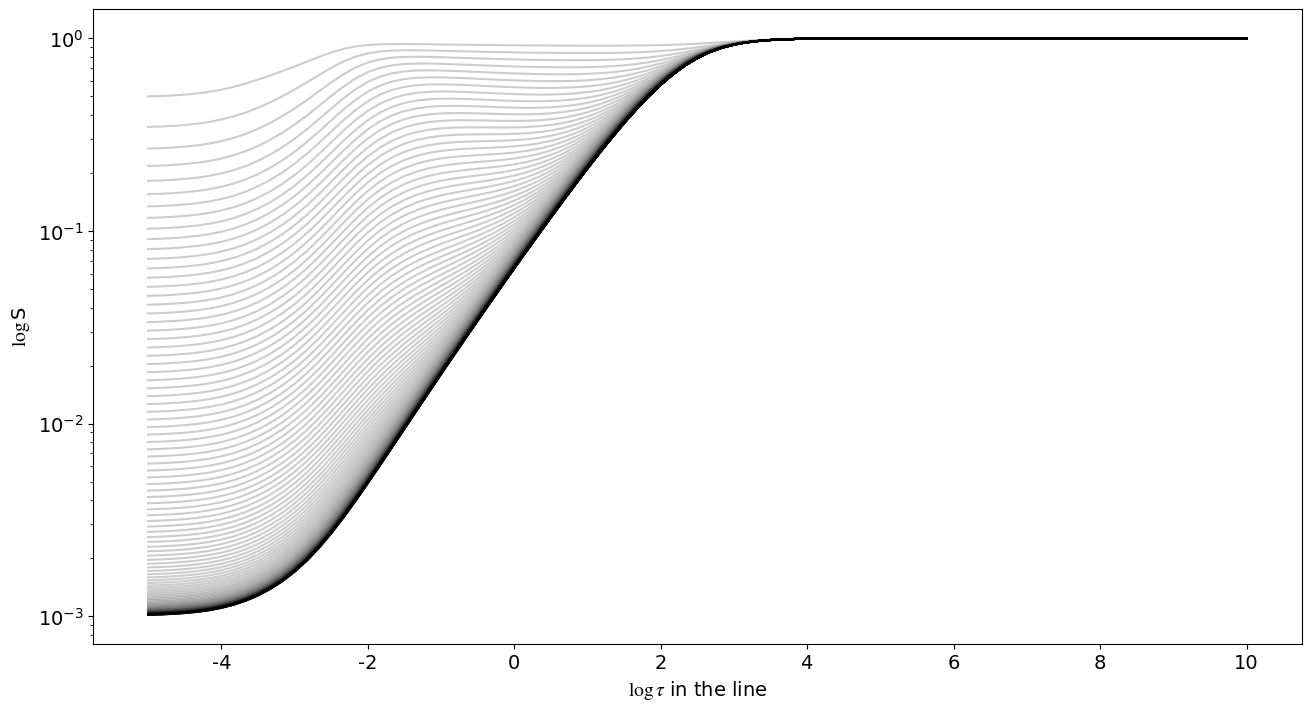

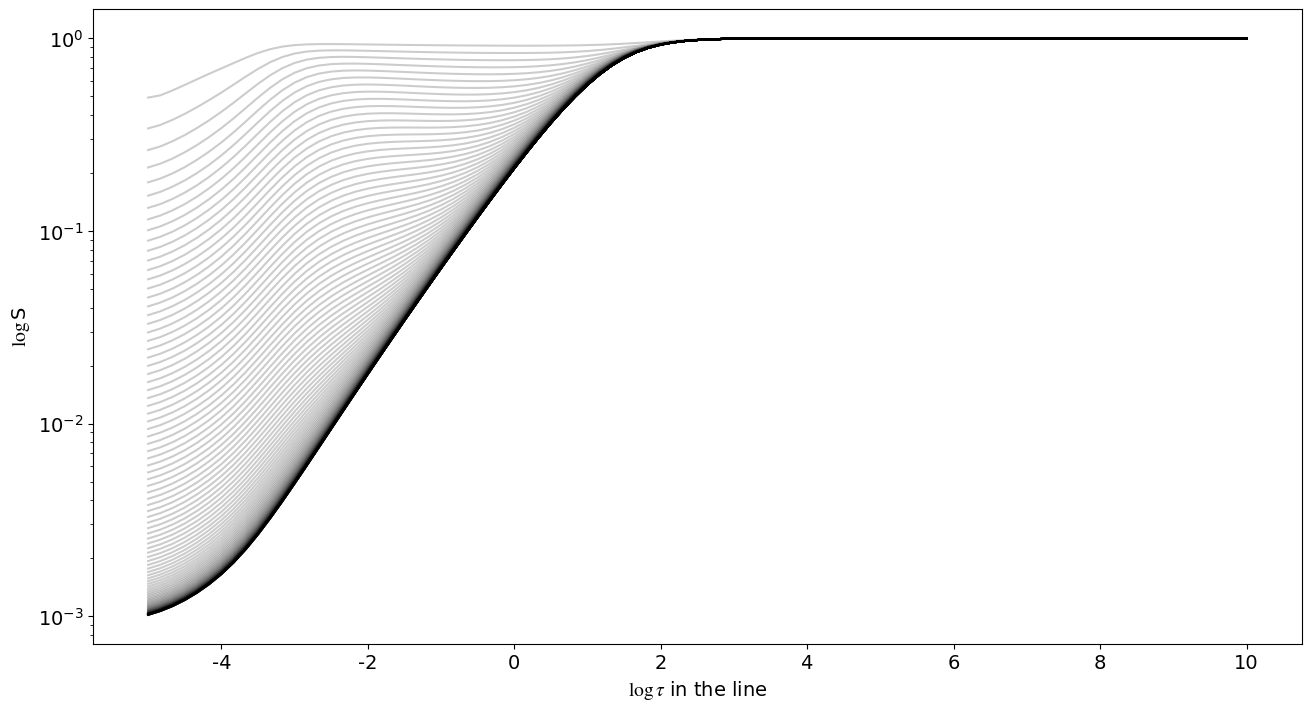

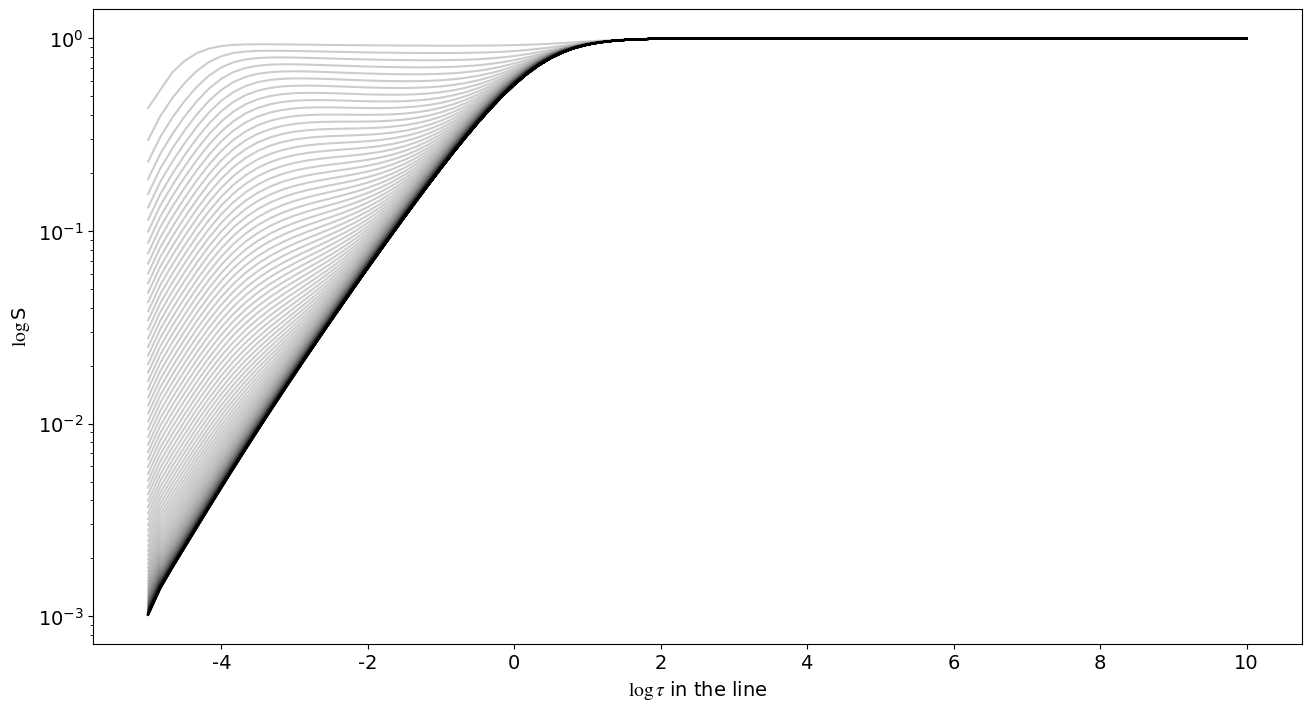

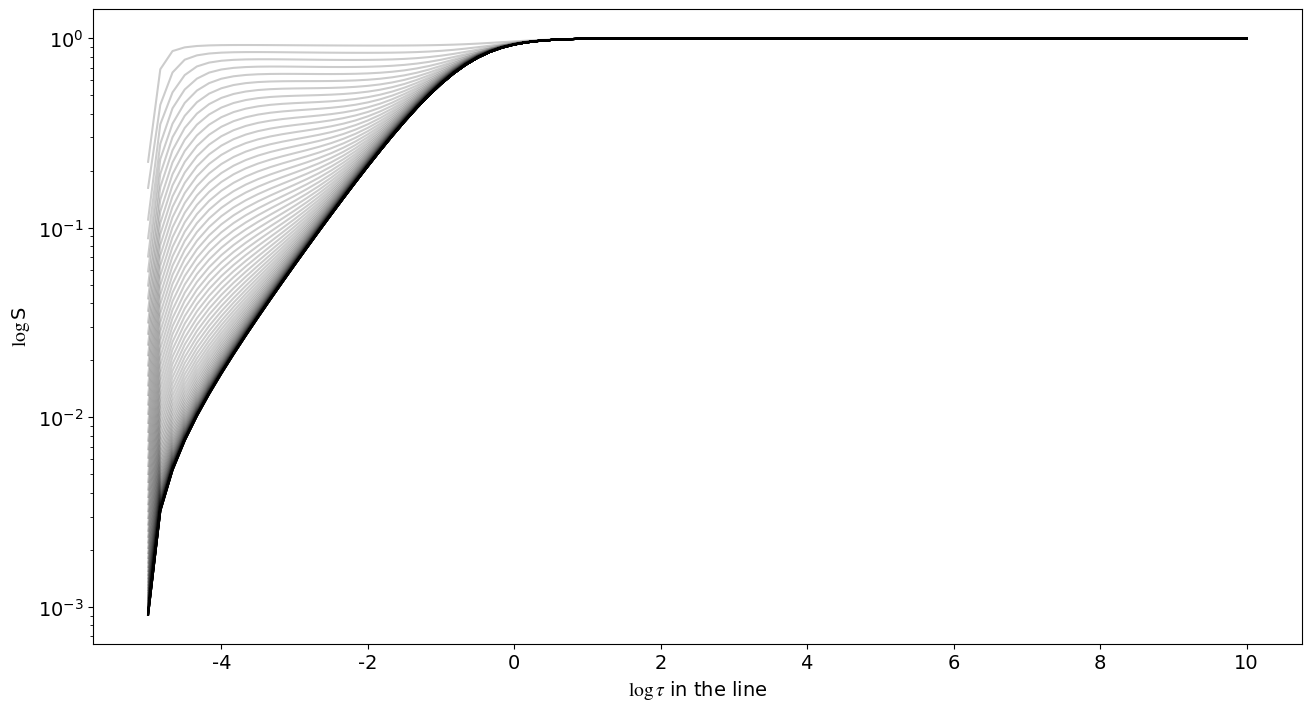

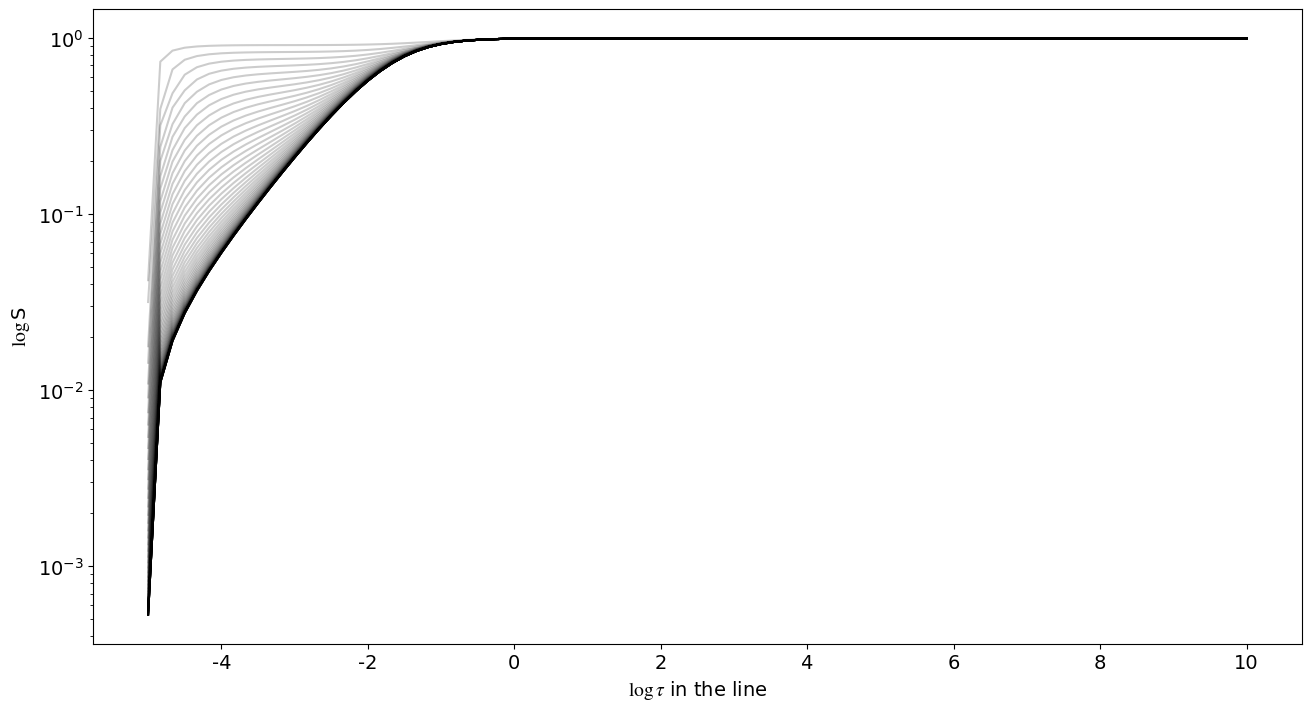

In [32]:
S_mockr1 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1)
S_mockr3 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
S_mockr4 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E4)
S_mockr5 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E5)
S_mockr6 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E6)
S_mockr7 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E7)

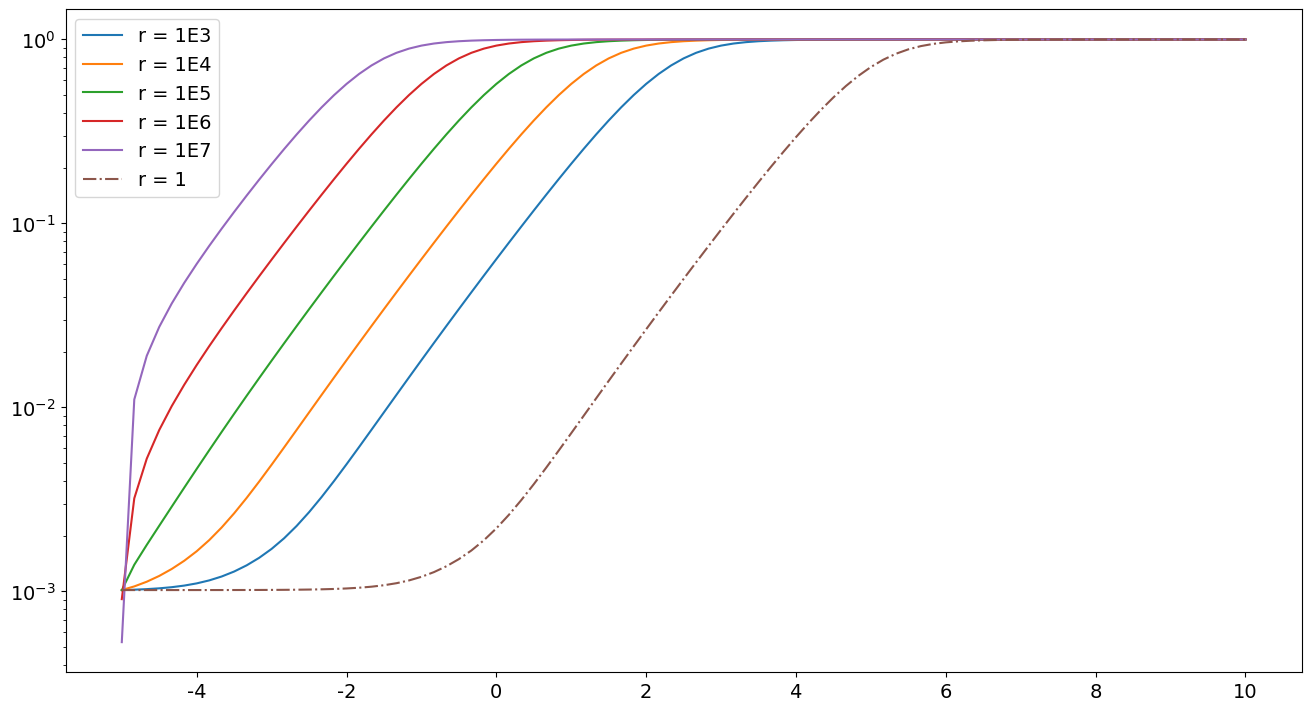

In [33]:
plt.figure(constrained_layout = True, figsize = (13, 7))
plt.semilogy(logtau_mock, S_mockr3, linestyle = "-", label = "r = 1E3")
plt.semilogy(logtau_mock, S_mockr4, linestyle = "-", label = "r = 1E4")
plt.semilogy(logtau_mock, S_mockr5, linestyle = "-", label = "r = 1E5")
plt.semilogy(logtau_mock, S_mockr6, linestyle = "-", label = "r = 1E6")
plt.semilogy(logtau_mock, S_mockr7, linestyle = "-", label = "r = 1E7")
plt.semilogy(logtau_mock, S_mockr1, linestyle = "-.", label = "r = 1")
plt.legend()

In [34]:
from sympy import symbols, Eq, solve

x, y, z = symbols('x, y, z')
eq0 = Eq(x + y + z, 1)
eq1 = Eq(0.88729833*x + 0.5*y + 0.11270167*z, 1/2)
eq2 = Eq(0.88729833**2*x + 0.5**2*y + 0.11270167**2*z, 1/3)
eq3 = Eq(0.88729833**3*x + 0.5**3*y + 0.11270167**3*z, 1/4)
eq4 = Eq(0.88729833**4*x + 0.5**4*y + 0.11270167**4*z, 1/5)
eq5 = Eq(0.88729833**5*x + 0.5**5*y + 0.11270167**5*z, 1/6)

solutions = solve([eq0, eq1, eq2], [x, y, z])
print(f"Symbolic solutions: {solutions}")

Symbolic solutions: {x: 0.277777784405947, y: 0.444444431188107, z: 0.277777784405947}


In [35]:
a, b, c, d = symbols('a, b, c, d')
eq0 = Eq(a + b + c + d, 1)
eq1 = Eq(0.06943184*a + 0.33000948*b + 0.66999052*c + 0.93056816*d, 1/2)
eq2 = Eq(0.06943184**2*a + 0.33000948**2*b + 0.66999052**2*c + 0.93056816**2*d, 1/3)
eq3 = Eq(0.06943184**3*a + 0.33000948**3*b + 0.66999052**3*c + 0.93056816**3*d, 1/4)

solutions = solve([eq0, eq1, eq2, eq3], [a, b, c, d])
print(f"Symbolic solutions: {solutions}")

Symbolic solutions: {a: 0.173927419815906, b: 0.326072580184089, c: 0.326072580184104, d: 0.173927419815900}


In [36]:
tau_mock = tau_grid(1E-4, 1E7, 12)
# Upper boundary affects the S!!!!!
# If taumin (tau_upper) = 1E-5 for instance, the results are very different!!!!
logtau_mock = np.log10(tau_mock)

11.0
10.698970004336019
129
0.08358570315887515
[1.00000000e-04 1.21223189e-04 1.46950614e-04 1.78138220e-04
 2.15944831e-04 2.61775209e-04 3.17332256e-04 3.84680279e-04
 4.66321700e-04 5.65290033e-04 6.85262603e-04 8.30697177e-04
 1.00699761e-03 1.22071461e-03 1.47978917e-03 1.79384761e-03
 2.17455928e-03 2.63607009e-03 3.19552822e-03 3.87372120e-03
 4.69584835e-03 5.69245710e-03 6.90057800e-03 8.36510069e-03
 1.01404418e-02 1.22925669e-02 1.49014415e-02 1.80640025e-02
 2.18977598e-02 2.65451627e-02 3.21788926e-02 3.90082797e-02
 4.72870805e-02 5.73229067e-02 6.94886553e-02 8.42363636e-02
 1.02114006e-01 1.23785854e-01 1.50057159e-01 1.81904073e-01
 2.20509917e-01 2.67309153e-01 3.24040678e-01 3.92812443e-01
 4.76179768e-01 5.77240298e-01 6.99749095e-01 8.48258165e-01
 1.02828559e+00 1.24652058e+00 1.51107200e+00 1.83176966e+00
 2.22052959e+00 2.69179677e+00 3.26308187e+00 3.95561189e+00
 4.79511886e+00 5.81279598e+00 7.04645663e+00 8.54193941e+00
 1.03548113e+01 1.25524324e+01 1.5216

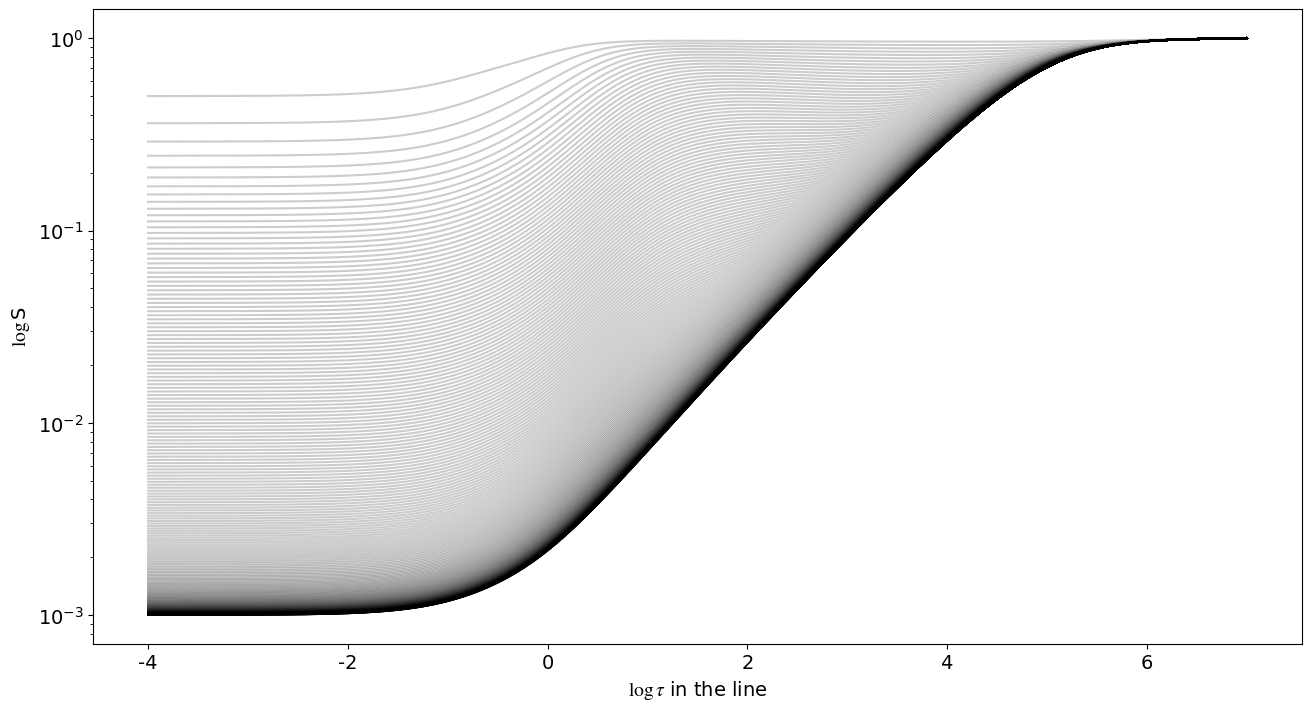

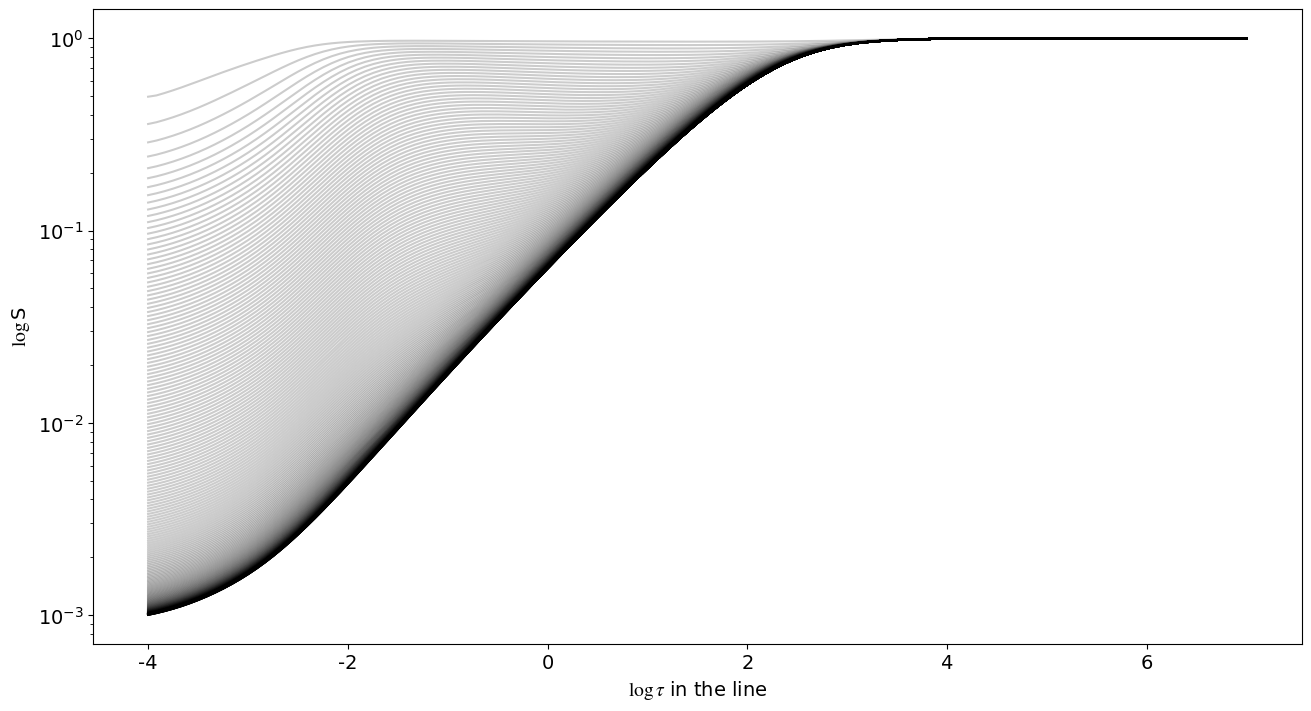

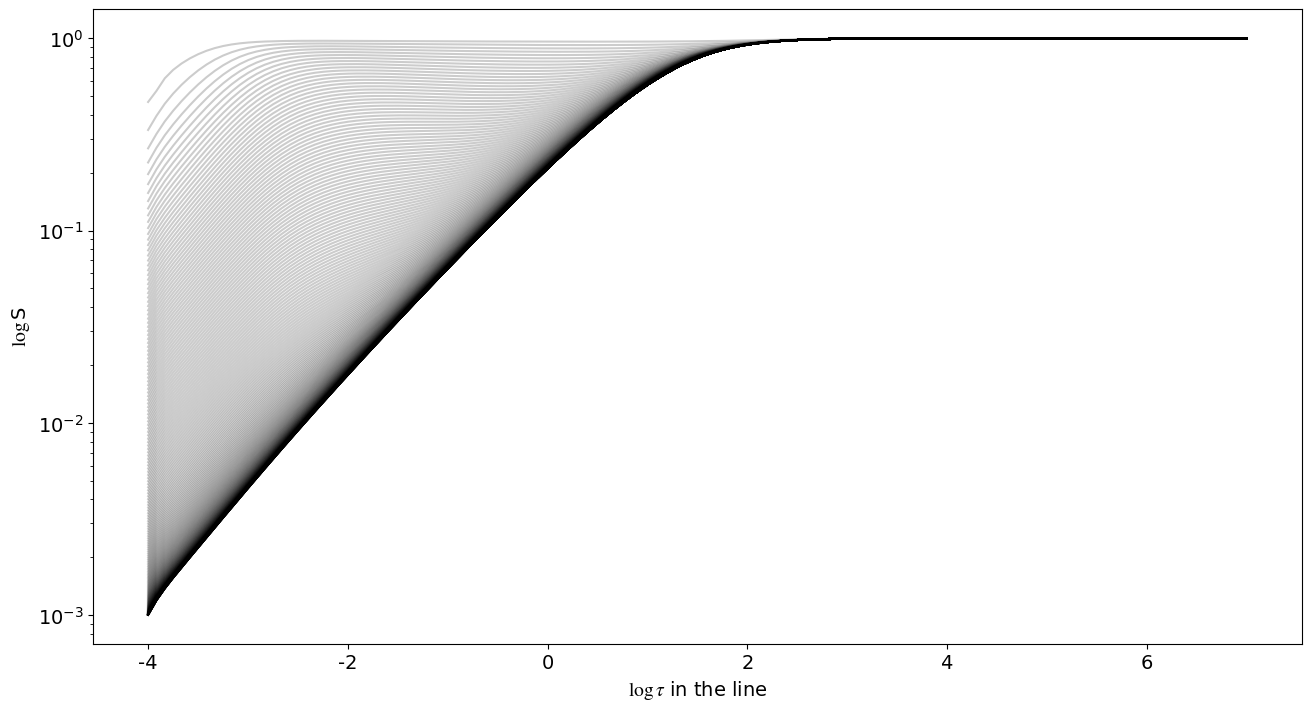

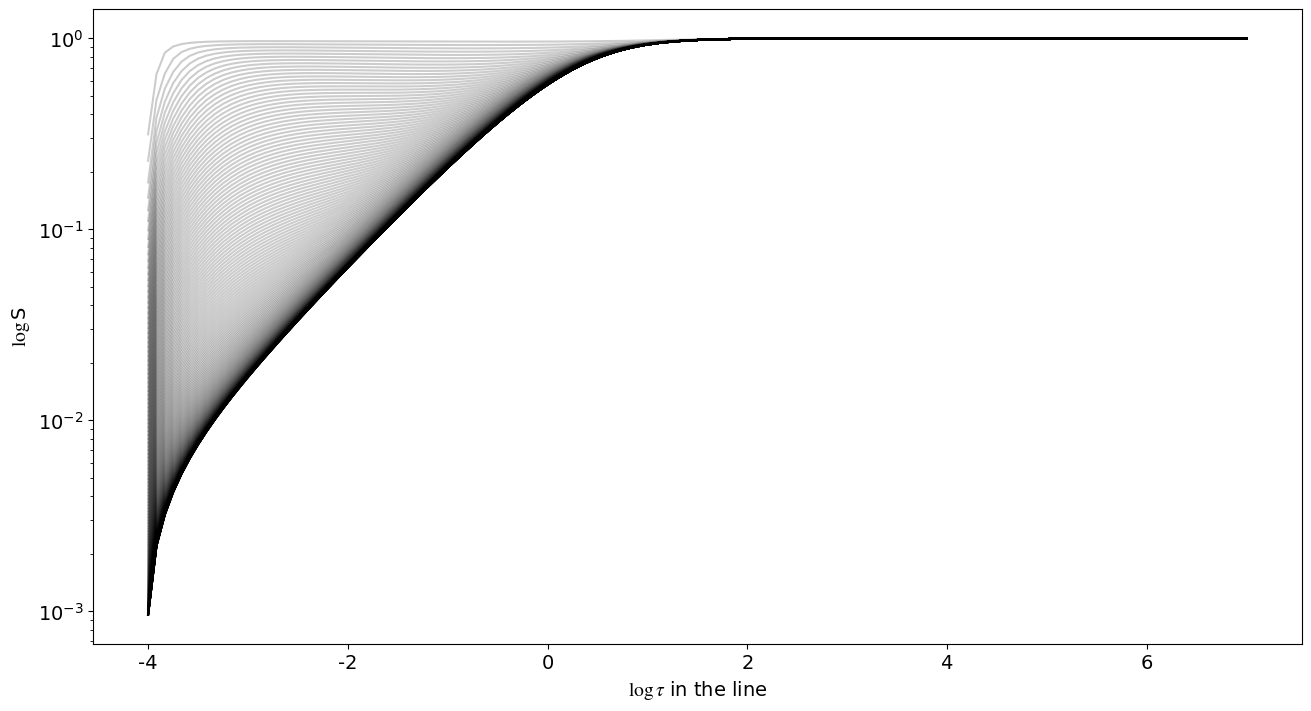

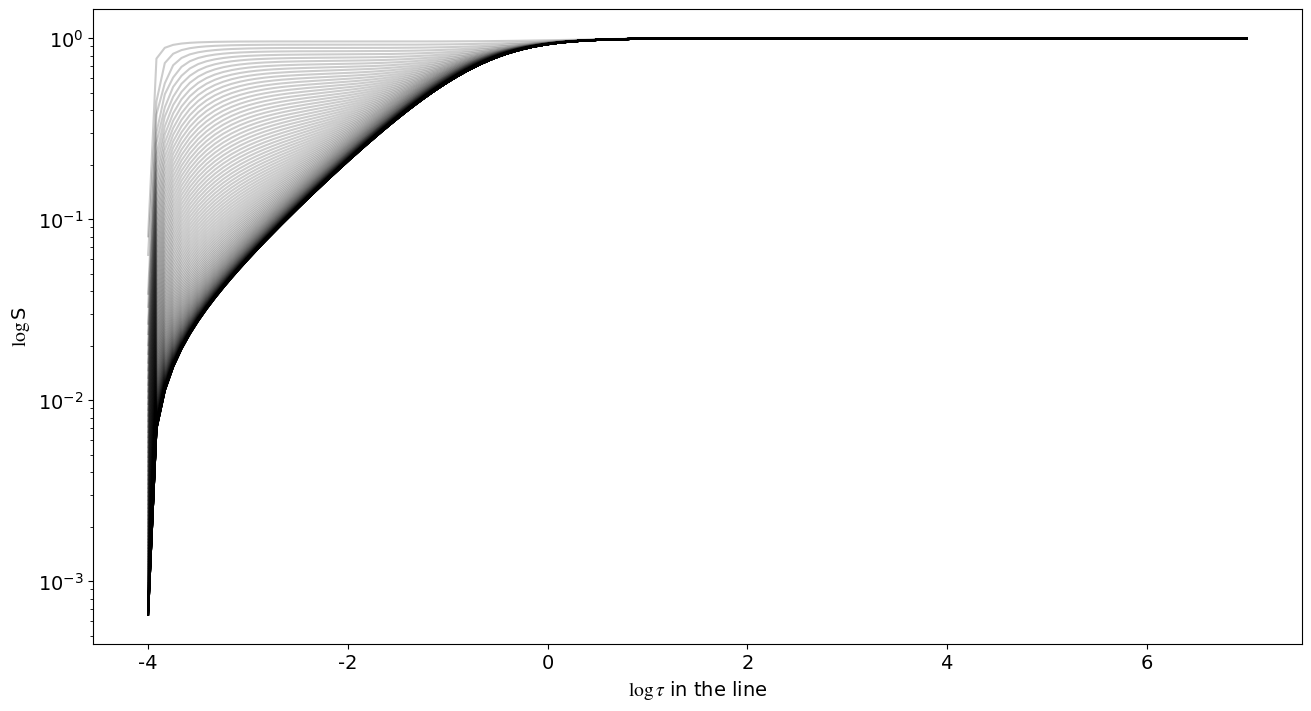

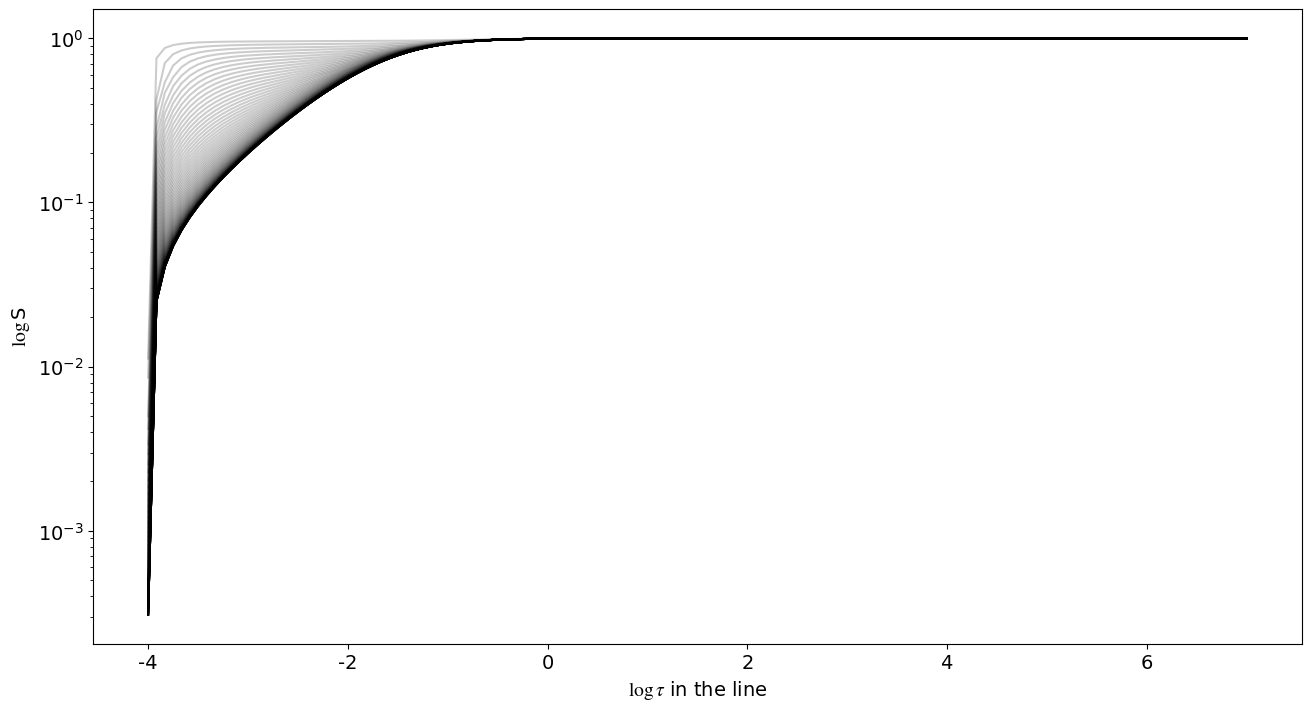

In [37]:
S_mockr1 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1)
S_mockr3 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
S_mockr4 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E4)
S_mockr5 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E5)
S_mockr6 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E6)
S_mockr7 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E7)

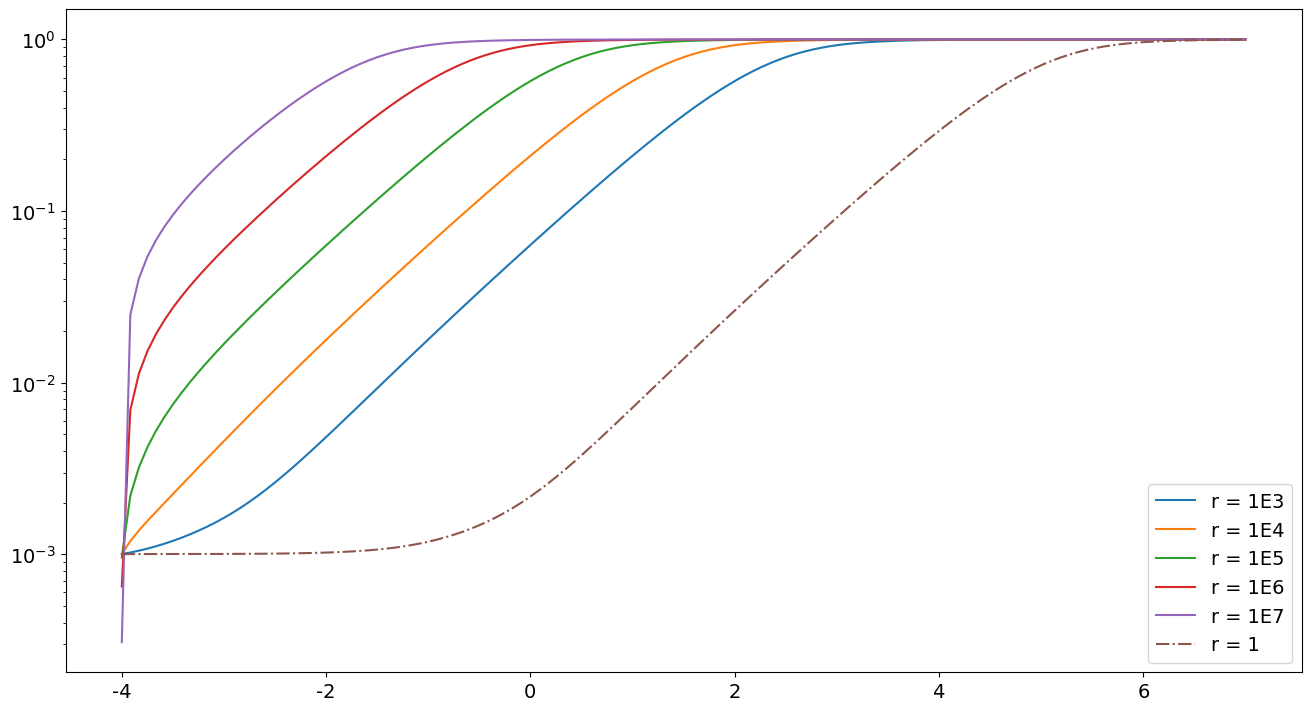

In [38]:
plt.figure(constrained_layout = True, figsize = (13, 7))
plt.semilogy(logtau_mock, S_mockr3, linestyle = "-", label = "r = 1E3")
plt.semilogy(logtau_mock, S_mockr4, linestyle = "-", label = "r = 1E4")
plt.semilogy(logtau_mock, S_mockr5, linestyle = "-", label = "r = 1E5")
plt.semilogy(logtau_mock, S_mockr6, linestyle = "-", label = "r = 1E6")
plt.semilogy(logtau_mock, S_mockr7, linestyle = "-", label = "r = 1E7")
plt.semilogy(logtau_mock, S_mockr1, linestyle = "-.", label = "r = 1")
plt.legend()